# Look at paths that were within DrugMechDB

Here we will look at the DrugMechDB paths contained within the network, and compare them to the actual paths selected by the model.

In [1]:
import pickle
import numpy as np
import pandas as pd
from pathlib import Path

%matplotlib inline
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
load_dir = Path('../2_pipeline').resolve()
model_name = '15_Final_Model_Training'

nw_dir = load_dir.joinpath('12d_Preprocessing-Abbreviations_and_Biolink', 'out')
hyp_dir = load_dir.joinpath('13c_Model_Prep_Hyperparam_tuning', 'out')
model_dir = load_dir.joinpath(model_name, 'out')

In [3]:
this_name = '16b_Model_results_analysis_DMDB'
out_dir = load_dir.joinpath(this_name, 'out')

out_dir.mkdir(exist_ok=True, parents=True)

In [4]:
nodes = pd.read_csv(nw_dir.joinpath('nodes_biolink.csv'), dtype=str)
edges = pd.read_csv(nw_dir.joinpath('edges_biolink.csv'), dtype=str)

In [5]:
best_param = pickle.load(open(hyp_dir.joinpath('best_param.pkl'), 'rb'))

In [6]:
from hetnet_ml.extractor import MatrixFormattedGraph
mg = MatrixFormattedGraph(nodes, edges, 'ChemicalSubstance', 'Disease', max_length=4, w=best_param['w'], n_jobs=30)

Processing node and edge data...
Initializing metagraph...
Generating adjacency matrices...


100%|██████████| 68/68 [00:54<00:00,  1.24it/s]



Determining degrees for each node and metaedge


100%|██████████| 68/68 [00:28<00:00,  2.42it/s]



Weighting matrices by degree with dampening factor 0.5665616931869023...


100%|██████████| 68/68 [00:00<00:00, 126.74it/s]


In [7]:
model = pickle.load(open(model_dir.joinpath('model.pkl'), 'rb'))

/opt/mmayers/software/anaconda3/envs/ml/lib/python3.6/site-packages/data_tools/df_processing.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [8]:
res = pd.read_csv(model_dir.joinpath('results.csv'))
coef = pd.read_csv(model_dir.joinpath('coef.csv'))
len(res)

90996724

In [9]:
metapaths = coef.query('feature != "intercept"')['feature'].tolist()

In [10]:
from data_tools.graphs import dataframes_to_metagraph, metapaths_to_json
metagraph = dataframes_to_metagraph(nodes, edges)

all_metapaths = metagraph.extract_metapaths('ChemicalSubstance', 'Disease', 4)
mp_info = {mp.abbrev: mp for mp in all_metapaths if mp.abbrev in metapaths}

In [11]:
id_to_name = nodes.set_index('id')['name'].to_dict()
res['chem_name'] = res['chemicalsubstance_id'].map(id_to_name)
res['dis_name'] = res['disease_id'].map(id_to_name)
res = res.sort_values('proba', ascending=False).reset_index(drop=True)

res.head(2)

chemicalsubstance_id     disease_id  status     proba          chem_name  \
0          CHEBI:53769  MONDO:0005399       0  0.997371  (S)-acenocoumarol   
1          CHEBI:50438  MONDO:0005399       0  0.997320      phenprocoumon   

                 dis_name  
0  venous thromboembolism  
1  venous thromboembolism

In [12]:
def find_nodes_by_name(sub_str, n_type=None):
    if n_type is not None:
        qr = nodes.query('label == @n_type')   
    else:
        qr = nodes
    
    return qr[qr['name'].str.contains(sub_str)]

In [13]:
pos_coef = coef.query('coef > 0')['feature'].tolist()

In [14]:
msat = model[0]
max_abs = model[1]

In [15]:
ini_means = {f: m for f, m in zip(metapaths, msat.initial_mean_)}
ma_scale = {f: m for f, m in zip(metapaths, max_abs.scale_)}
feat_coef = coef.set_index('feature')['coef'].to_dict()
feat_zcoef = coef.set_index('feature')['zcoef'].to_dict()

In [16]:
def get_model_metric(path_df):
    totals = path_df.groupby('metapath')['metric'].sum().to_dict()
    percent_of_total = path_df['metric'] / path_df['metapath'].map(totals)
    
    trans_metric = np.arcsinh(path_df['metapath'].map(totals) / path_df['metapath'].map(ini_means))
    scal_metric = trans_metric / path_df['metapath'].map(ma_scale)
    
    model_metric = scal_metric * path_df['metapath'].map(feat_coef) * percent_of_total
    return model_metric

In [17]:
def get_std_model_metric(path_df):
    
    totals = path_df.groupby('metapath')['metric'].sum().to_dict()
    percent_of_total = path_df['metric'] / path_df['metapath'].map(totals)
    
    trans_metric = np.arcsinh(path_df['metric'] / path_df['metapath'].map(ini_means))
    scal_metric = trans_metric / path_df['metapath'].map(ma_scale)
    
    model_metric = scal_metric * path_df['metapath'].map(feat_zcoef) * percent_of_total
    return model_metric

In [18]:
def get_scal_dwpc_metric(path_df):
    totals = path_df.groupby('metapath')['metric'].sum().to_dict()
    percent_of_total = path_df['metric'] / path_df['metapath'].map(totals)
    
    trans_metric = np.arcsinh(path_df['metapath'].map(totals) / path_df['metapath'].map(ini_means))
    scal_metric = trans_metric / path_df['metapath'].map(ma_scale)
    
    dwpc_metric = scal_metric * percent_of_total
    return dwpc_metric

In [19]:
def get_path_info(compound, disease, n_jobs=30, mps=None):
    if mps == None:
        mps = pos_coef
    
    path_df = pd.DataFrame(mg.extract_paths(compound, disease, mps, n_jobs=n_jobs))
    if len(path_df) > 0:
        path_df['model_metric'] = get_model_metric(path_df)
        path_df['std_metric'] = get_std_model_metric(path_df)
        path_df['scal_metric'] = get_scal_dwpc_metric(path_df)
    
    return path_df

## Load in the DrugMechDB Paths

In [20]:
dmdb_paths = pd.read_csv('../2_pipeline/MOA_Analysis-Biolink/out/mapped_vs_missing.csv')

In [21]:
clean_paths = []
chem_ids = []
dis_ids = []
path_pairs = []

for row in dmdb_paths.itertuples(index=False):
    skip = False
    prev = row[0]   
    for n in row:
        if n == "missing":
            skip = True
            break
        elif pd.isnull(n):
            break
        if not skip:
            prev = n
        
    if not skip:
        chem_ids.append(row[0])
        dis_ids.append(prev)
        path_pairs.append((row[0], prev))
        clean_paths.append(row)

In [22]:
dmdb_paths = pd.DataFrame(clean_paths).drop_duplicates()

In [23]:
len(dmdb_paths)

142

In [24]:
feature_order = pd.read_csv(model_dir.joinpath('feature_order.txt'), header=None)[0].tolist()

In [25]:
chem_to_extract = list(set(chem_ids))

In [26]:
# Some "Diseases" may be phenotypes, so we should enforce diseaes for extraction
dis_to_extract = list(set(nodes.query('label == "Disease"')['id']) & set(dis_ids))

In [27]:
(dmdb_pairs, out_mp), dwpc = mg.extract_dwpc(metapaths=feature_order, start_nodes=chem_to_extract, 
                                        end_nodes=dis_to_extract, n_jobs=30, return_sparse=True, sparse_df=False)

Preparing function arguments...
Calculating DWPCs...


100%|██████████| 156/156 [03:03<00:00,  1.17s/it]



Reshaping Result Matrices...


100%|██████████| 156/156 [00:00<00:00, 2227.92it/s]

Stacking columns...


In [28]:
dmdb_pairs['proba'] = model.predict_proba(dwpc)[:, 1]

In [29]:
dmdb_pairs['chem_name'] = dmdb_pairs['chemicalsubstance_id'].map(id_to_name)
dmdb_pairs['dis_name'] = dmdb_pairs['disease_id'].map(id_to_name)

In [30]:
pos_tups = set(edges.query('type == "treats_CtD"')[['start_id', 'end_id']].apply(tuple, axis=1))

In [31]:
status = []
for row in dmdb_pairs.itertuples():
    tup = (row.chemicalsubstance_id, row.disease_id)
    status.append(int(bool(pos_tups & {tup})))

In [32]:
dmdb_pairs['status'] = status
dmdb_pairs.sample(10)

chemicalsubstance_id    disease_id     proba  \
1554                       CHEBI:31441     DOID:2891  0.034717   
3345                        CHEBI:5384  DOID:0050758  0.004046   
4190                       CHEBI:74789    DOID:10787  0.008884   
5778                   UNII:9ML606PR4C  DOID:0060192  0.005413   
1564                       CHEBI:31441     DOID:4481  0.004726   
5933                   UNII:KXG2PJ551I  DOID:0060851  0.005413   
1513                        CHEBI:3077     DOID:8741  0.038456   
4131                       CHEBI:73275     DOID:1825  0.003908   
4936                        CHEBI:8357     DOID:9182  0.000467   
5575  IKEY:HJBWBFZLDZWPHF-UHFFFAOYSA-N     DOID:1825  0.005957   

                   chem_name                    dis_name  status  
1554  fluticasone propionate             thyroid adenoma       0  
3345               glipizide          metabolic acidosis       0  
4190         9-aminoacridine         premature menopause       0  
5778       Follitropin Alpha             Crohn's colitis       0  
1564  fluticasone propionate           allergic rhinitis       0  
5933                Avelumab          pemphigus vulgaris       0  
1513           betamethasone       seborrheic dermatitis       1  
4131              ospemifene  childhood absence epilepsy       0  
4936              pramocaine                   pemphigus       0  
5575                  ARN509  childhood absence epilepsy       0

In [33]:
dmdb_pairs.to_csv(out_dir.joinpath('dmdb_probas.csv'), index=False)

In [34]:
dmdb_pairs = dmdb_pairs.sort_values('proba', ascending=False)

In [35]:
dmdb_pairs['tup'] = dmdb_pairs[['chemicalsubstance_id', 'disease_id']].apply(tuple, axis=1)

In [36]:
dmdb_pairs.query('tup in @path_pairs')

chemicalsubstance_id    disease_id     proba                chem_name  \
3265          CHEBI:53769     DOID:9477  0.988792        (S)-acenocoumarol   
149           CHEBI:10033     DOID:9477  0.950225                 warfarin   
3961           CHEBI:6942    DOID:10763  0.924148                minoxidil   
1427          CHEBI:29081    DOID:60164  0.805164               synephrine   
3783           CHEBI:6456    DOID:60164  0.804411                lidocaine   
...                   ...           ...       ...                      ...   
3041           CHEBI:5141  DOID:0050758  0.005307               fomepizole   
1069          CHEBI:15956  DOID:0060851  0.005254                   biotin   
1316          CHEBI:28312     DOID:1483  0.005136  chlorhexidine gluconate   
1328          CHEBI:28312     DOID:3388  0.005113  chlorhexidine gluconate   
4080          CHEBI:72291      DOID:526  0.003542               cobicistat   

                                             dis_name  status  \
3265                               pulmonary embolism       0   
149                                pulmonary embolism       1   
3961                                     hypertension       1   
1427                                      Pain relief       0   
3783                                      Pain relief       1   
...                                               ...     ...   
3041                               metabolic acidosis       0   
1069                               pemphigus vulgaris       0   
1316                                 gingival disease       1   
1328                              periodontal disease       1   
4080  human immunodeficiency virus infectious disease       1   

                              tup  
3265     (CHEBI:53769, DOID:9477)  
149      (CHEBI:10033, DOID:9477)  
3961     (CHEBI:6942, DOID:10763)  
1427    (CHEBI:29081, DOID:60164)  
3783     (CHEBI:6456, DOID:60164)  
...                           ...  
3041   (CHEBI:5141, DOID:0050758)  
1069  (CHEBI:15956, DOID:0060851)  
1316     (CHEBI:28312, DOID:1483)  
1328     (CHEBI:28312, DOID:3388)  
4080      (CHEBI:72291, DOID:526)  

[114 rows x 7 columns]

In [37]:
def get_pair_idx(idx, df):

    cid = df.loc[idx, 'chemicalsubstance_id']
    did = df.loc[idx, 'disease_id']
    prob = df.loc[idx, 'proba']

    print('Extracting data for: {} -TREATS- {}'.format(id_to_name[cid], id_to_name[did]))
    try:
        path_df = get_path_info(cid, did, 30)
    except:
        path_df = get_path_info(cid, did, 1)
    if len(path_df) == 0:
        return path_df
    return path_df.sort_values('model_metric', ascending=False).reset_index(drop=True)

In [38]:
from tqdm import tqdm

## Extract all paths for indications in DrugMechDB

In [39]:
dmdb_res = dmdb_pairs.query('tup in @path_pairs')

In [40]:
path_res = dict()

for f in out_dir.iterdir():
    if f.name.startswith('paths_'):
        try:
            test_path = pd.read_csv(f, converters={'nodes': eval, 'node_ids': eval, 'node_id_tup': eval})
            start_id = f.name.split('_')[1]
            end_id = f.name.split('_')[2].rstrip('.csv')

            path_res[(start_id, end_id)] = test_path
        except:
            pass

In [41]:
# Extract_new pairs if needed...
remain_pairs = set(path_pairs) - set(path_res.keys())
# Extract the paths
to_query = dmdb_res.query('tup in @remain_pairs')
for row in tqdm(to_query.itertuples(), total=len(to_query)):
    this_path = get_pair_idx(row.Index, dmdb_res)
    if len(this_path) == 0:
        print('Warning, no paths')
    path_res[row.tup] = this_path
    # Save so it never needs to be done again...
    path_res[row.tup].to_csv(out_dir.joinpath('paths_{0}_{1}.csv'.format(*row.tup)), index=False)

  0%|          | 0/61 [00:00<?, ?it/s]

Extracting data for: synephrine -TREATS- Pain relief



  2%|▏         | 1/61 [13:45<13:45:20, 825.34s/it]

Extracting data for: lidocaine -TREATS- Pain relief



  3%|▎         | 2/61 [16:06<10:09:37, 619.95s/it]

Extracting data for: pramocaine -TREATS- Pain relief



  5%|▍         | 3/61 [16:19<7:03:20, 437.94s/it] 

Extracting data for: synephrine -TREATS- Pain



  7%|▋         | 4/61 [22:34<6:38:17, 419.25s/it]

Extracting data for: phenobarbital -TREATS- epilepsy



  8%|▊         | 5/61 [32:35<7:22:09, 473.74s/it]

Extracting data for: (2R)-2-(6-methoxy-2-naphthalenyl)propanoic acid -TREATS- Pain relief



 10%|▉         | 6/61 [35:36<5:53:47, 385.95s/it]

Extracting data for: acetylsalicylate -TREATS- Pain relief



 11%|█▏        | 7/61 [42:11<5:49:48, 388.67s/it]

Extracting data for: (S)-aminoglutethimide -TREATS- breast carcinoma



 13%|█▎        | 8/61 [43:28<4:20:34, 294.99s/it]

Extracting data for: anastrozole -TREATS- breast carcinoma



 15%|█▍        | 9/61 [43:46<3:03:33, 211.79s/it]

Extracting data for: (S)-aminoglutethimide -TREATS- breast cancer



 16%|█▋        | 10/61 [45:03<2:25:49, 171.56s/it]

Extracting data for: anastrozole -TREATS- breast cancer



 18%|█▊        | 11/61 [45:21<1:44:26, 125.33s/it]

Extracting data for: pramocaine -TREATS- Pain



 20%|█▉        | 12/61 [45:37<1:15:42, 92.70s/it] 

Extracting data for: lidocaine -TREATS- Pain



 21%|██▏       | 13/61 [47:09<1:13:54, 92.39s/it]

Extracting data for: pimozide -TREATS- Gilles de la Tourette syndrome



 23%|██▎       | 14/61 [47:26<54:36, 69.72s/it]  

Extracting data for: ziprasidone mesylate trihydrate -TREATS- schizophrenia



 25%|██▍       | 15/61 [48:01<45:26, 59.27s/it]

Extracting data for: meloxicam -TREATS- Pain relief



 26%|██▌       | 16/61 [49:06<45:51, 61.15s/it]

Extracting data for: acetylsalicylate -TREATS- Pain



 28%|██▊       | 17/61 [53:51<1:33:58, 128.15s/it]

Extracting data for: (2R)-2-(6-methoxy-2-naphthalenyl)propanoic acid -TREATS- Pain



 30%|██▉       | 18/61 [56:06<1:33:23, 130.31s/it]

Extracting data for: ivermectin -TREATS- onchocerciasis



 31%|███       | 19/61 [56:22<1:07:16, 96.11s/it] 

Extracting data for: meloxicam -TREATS- Pain



 33%|███▎      | 20/61 [57:14<56:38, 82.88s/it]  

Extracting data for: Trimethadione -TREATS- childhood absence epilepsy



 34%|███▍      | 21/61 [57:32<42:11, 63.30s/it]

Extracting data for: Trimethadione -TREATS- absence epilepsy



 36%|███▌      | 22/61 [57:47<31:49, 48.96s/it]

Extracting data for: mosapramine -TREATS- schizophrenia



 38%|███▊      | 23/61 [58:03<24:41, 39.00s/it]

Extracting data for: anastrozole -TREATS- Breast cancer in postmenopausal women with osteoporosis



 39%|███▉      | 24/61 [58:21<20:10, 32.71s/it]

Extracting data for: (S)-aminoglutethimide -TREATS- Breast cancer in postmenopausal women with osteoporosis



 41%|████      | 25/61 [59:42<28:17, 47.15s/it]

Extracting data for: anastrozole -TREATS- ER-negative breast cancers



 43%|████▎     | 26/61 [1:00:00<22:19, 38.26s/it]

Extracting data for: anastrozole -TREATS- Estrogen-receptor positive early breast cancer



 44%|████▍     | 27/61 [1:00:19<18:29, 32.63s/it]

Extracting data for: anastrozole -TREATS- Advanced hormone receptor-positive, HER2­ negative breast cancer



 46%|████▌     | 28/61 [1:00:36<15:25, 28.05s/it]

Extracting data for: (S)-aminoglutethimide -TREATS- ER-negative breast cancers



 48%|████▊     | 29/61 [1:01:52<22:37, 42.41s/it]

Extracting data for: (S)-aminoglutethimide -TREATS- Estrogen-receptor positive early breast cancer



 49%|████▉     | 30/61 [1:04:36<40:38, 78.65s/it]

Extracting data for: (S)-aminoglutethimide -TREATS- Advanced hormone receptor-positive, HER2­ negative breast cancer



 51%|█████     | 31/61 [1:05:53<39:10, 78.34s/it]

Extracting data for: glipizide -TREATS- hyperglycemia



 52%|█████▏    | 32/61 [1:06:13<29:27, 60.94s/it]

Extracting data for: abacavir -TREATS- human immunodeficiency virus infectious disease



 54%|█████▍    | 33/61 [1:06:51<25:09, 53.91s/it]

Extracting data for: Terfenadine -TREATS- allergic contact dermatitis



 56%|█████▌    | 34/61 [1:08:45<32:20, 71.86s/it]

Extracting data for: dexamethasone -TREATS- tenosynovitis



 57%|█████▋    | 35/61 [1:09:52<30:30, 70.39s/it]

Extracting data for: ofloxacin -TREATS- pyelonephritis



 59%|█████▉    | 36/61 [1:10:17<23:39, 56.79s/it]

Extracting data for: voclosporin -TREATS- uveitis



 61%|██████    | 37/61 [1:10:36<18:11, 45.50s/it]

Extracting data for: norfloxacin -TREATS- shigellosis



 62%|██████▏   | 38/61 [1:10:55<14:25, 37.64s/it]

Extracting data for: hemin -TREATS- acute intermittent porphyria



 64%|██████▍   | 39/61 [1:11:19<12:14, 33.40s/it]

Extracting data for: fomepizole -TREATS- Acidosis



 66%|██████▌   | 40/61 [1:11:37<10:07, 28.92s/it]

Extracting data for: fluticasone propionate -TREATS- bronchitis



 67%|██████▋   | 41/61 [1:11:55<08:28, 25.44s/it]

Extracting data for: Cortisone acetate -TREATS- keratitis



 69%|██████▉   | 42/61 [1:12:14<07:28, 23.61s/it]

Extracting data for: afamelanotide -TREATS- erythropoietic protoporphyria



 70%|███████   | 43/61 [1:12:33<06:41, 22.31s/it]

Extracting data for: chlorhexidine gluconate -TREATS- periodontitis



 72%|███████▏  | 44/61 [1:12:52<06:02, 21.32s/it]

Extracting data for: Follitropin Alpha -TREATS- premature menopause



 74%|███████▍  | 45/61 [1:13:09<05:20, 20.00s/it]

Warning, no paths
Extracting data for: Thyrotropin Alfa -TREATS- thyroid adenoma



 75%|███████▌  | 46/61 [1:13:26<04:47, 19.18s/it]

Warning, no paths
Extracting data for: Pegaspargase -TREATS- T-cell lymphoblastic lymphoma



 77%|███████▋  | 47/61 [1:13:44<04:20, 18.58s/it]

Warning, no paths
Extracting data for: Thyrotropin Alfa -TREATS- thyroid gland cancer



 79%|███████▊  | 48/61 [1:14:04<04:08, 19.11s/it]

Warning, no paths
Extracting data for: Follitropin Alpha -TREATS- premature ovarian failure



 80%|████████  | 49/61 [1:14:21<03:42, 18.56s/it]

Warning, no paths
Extracting data for: Avelumab -TREATS- Merkel cell carcinoma



 82%|████████▏ | 50/61 [1:14:41<03:27, 18.84s/it]

Warning, no paths
Extracting data for: Thyrotropin Alfa -TREATS- thyroid gland carcinoma



 84%|████████▎ | 51/61 [1:14:58<03:04, 18.44s/it]

Warning, no paths
Extracting data for: levocabastine -TREATS- giant papillary conjunctivitis



 85%|████████▌ | 52/61 [1:15:16<02:43, 18.18s/it]

Warning, no paths
Extracting data for: levocabastine -TREATS- vernal conjunctivitis



 87%|████████▋ | 53/61 [1:15:35<02:28, 18.54s/it]

Warning, no paths
Extracting data for: Tazanolast -TREATS- giant papillary conjunctivitis



 89%|████████▊ | 54/61 [1:15:53<02:08, 18.29s/it]

Warning, no paths
Extracting data for: Tazanolast -TREATS- vernal conjunctivitis



 90%|█████████ | 55/61 [1:16:12<01:51, 18.65s/it]

Warning, no paths
Extracting data for: clortermine -TREATS- anorexia nervosa



 92%|█████████▏| 56/61 [1:16:30<01:31, 18.28s/it]

Warning, no paths
Extracting data for: Tazanolast -TREATS- allergic conjunctivitis



 93%|█████████▎| 57/61 [1:16:50<01:15, 18.75s/it]

Extracting data for: fomepizole -TREATS- metabolic acidosis



 95%|█████████▌| 58/61 [1:17:08<00:56, 18.68s/it]

Extracting data for: chlorhexidine gluconate -TREATS- gingival disease



 97%|█████████▋| 59/61 [1:17:29<00:38, 19.43s/it]

Extracting data for: chlorhexidine gluconate -TREATS- periodontal disease



 98%|█████████▊| 60/61 [1:17:49<00:19, 19.37s/it]

Extracting data for: cobicistat -TREATS- human immunodeficiency virus infectious disease



100%|██████████| 61/61 [1:18:06<00:00, 76.82s/it]


In [42]:
path_res = {k: v for k, v in path_res.items() if len(v) > 0}

In [43]:
from collections import defaultdict

In [44]:
def query_target(path_df, tgt_id):
    tgt_ids = path_df['node_ids'].apply(lambda x: x[1])
    
    idx = tgt_ids == tgt_id
    idx = idx[idx].index
    
    return path_df.loc[idx]

In [45]:
dmdb_paths

n1                  n2           n3              n4  \
0        CHEBI:31690         NCBIGene:25    DOID:8552             NaN   
1        CHEBI:31690       NCBIGene:3815   GO:0008283        DOID:349   
2        CHEBI:31690       NCBIGene:3815   GO:0008283       DOID:4798   
3        CHEBI:31690       NCBIGene:3815   GO:0008283       DOID:4660   
4        CHEBI:31690       NCBIGene:5156   GO:0008283        DOID:349   
..               ...                 ...          ...             ...   
138       CHEBI:6078  InterPro:IPR015680  CHEBI:17996      GO:0060081   
139       CHEBI:6078  InterPro:IPR015680  CHEBI:17996      GO:0060081   
140      CHEBI:72291      NCBIGene:64816  CHEBI:37924  UniProt:P04585   
141  UNII:KXG2PJ551I      NCBIGene:29126   GO:0036037      GO:0008283   
142  UNII:KXG2PJ551I      NCBIGene:29126   GO:0036037      GO:0008283   

             n5              n6          n7   n8  
0           NaN             NaN         NaN  NaN  
1           NaN             NaN         NaN  NaN  
2           NaN             NaN         NaN  NaN  
3           NaN             NaN         NaN  NaN  
4           NaN             NaN         NaN  NaN  
..          ...             ...         ...  ...  
138  DOID:80000  NCBITaxon:6282  DOID:11678  NaN  
139  HP:0003470  NCBITaxon:6282  DOID:11678  NaN  
140  GO:0019068        DOID:526         NaN  NaN  
141  HP:0030447             NaN         NaN  NaN  
142   DOID:3965             NaN         NaN  NaN  

[142 rows x 8 columns]

## Summarize the findings from DMDB

In [46]:
summary_info = defaultdict(list)

for i, pair in enumerate(path_pairs):
    if pair not in path_res.keys():
        continue
        
    this_res = path_res[pair]
    
    info = dmdb_res.query('tup == @pair')
    
    this_chem = info.iloc[0]['chem_name']
    this_dis = info.iloc[0]['dis_name']
    this_prob = info.iloc[0]['proba']
    
    path_tup = tuple(dmdb_paths.loc[i].dropna())
    
    #make queryable by conveting to tuple
    this_res['node_id_tup'] = this_res['node_ids'].apply(tuple)
    
    # get the results that have the desired target
    tgt_res = query_target(this_res, path_tup[1])
    tgt_res = tgt_res.reset_index().rename(columns={'index': 'old_idx'})
    
    found = this_res.query('node_id_tup == @path_tup')
    
    if len(found) == 0:
        summary_info['chem_name'].append(this_chem)
        summary_info['dis_name'].append(this_dis)
        summary_info['chem_id'].append(path_tup[0])
        summary_info['dis_id'].append(path_tup[-1])
        summary_info['treat_prob'].append(this_prob)
        summary_info['model_metric'].append(float('nan'))
        summary_info['metapath'].append(float('nan'))
        summary_info['overall_rank'].append(float('nan'))
        summary_info['total_paths'].append(len(this_res))
        summary_info['tgt_rank'].append(float('nan'))
        summary_info['tgt_paths'].append(len(tgt_res))
        summary_info['mp_rank'].append(float('nan'))
        summary_info['mp_paths'].append(float('nan'))

    
    for row in found.itertuples():
        mp = row.metapath
        idx = row.Index
        mp_res = this_res.query('metapath == @mp').reset_index().rename(columns={'index': 'old_idx'})
        
        summary_info['chem_name'].append(this_chem)
        summary_info['dis_name'].append(this_dis)
        summary_info['chem_id'].append(path_tup[0])
        summary_info['dis_id'].append(path_tup[-1])
        summary_info['treat_prob'].append(this_prob)
        summary_info['model_metric'].append(row.model_metric)
        summary_info['metapath'].append(row.metapath)
        summary_info['overall_rank'].append(int(row.Index)+1)
        summary_info['total_paths'].append(len(this_res))
        summary_info['tgt_rank'].append(int(tgt_res.query('old_idx == @idx').iloc[0].name)+1)
        summary_info['tgt_paths'].append(len(tgt_res))
        summary_info['mp_rank'].append(int(mp_res.query('old_idx == @idx').iloc[0].name)+1)
        summary_info['mp_paths'].append(len(mp_res))

summary_df = pd.DataFrame(summary_info)
summary_df

chem_name  \
0        imatinib methanesulfonate   
1        imatinib methanesulfonate   
2        imatinib methanesulfonate   
3        imatinib methanesulfonate   
4        imatinib methanesulfonate   
..                             ...   
127                9-aminoacridine   
128  diphenhydramine hydrochloride   
129                     ivermectin   
130                     ivermectin   
131                     cobicistat   

                                            dis_name      chem_id      dis_id  \
0                           chronic myeloid leukemia  CHEBI:31690   DOID:8552   
1                           chronic myeloid leukemia  CHEBI:31690   DOID:8552   
2                              systemic mastocytosis  CHEBI:31690    DOID:349   
3                   aggressive systemic mastocytosis  CHEBI:31690   DOID:4798   
4                     indolent systemic mastocytosis  CHEBI:31690   DOID:4660   
..                                               ...          ...         ...   
127                            pityriasis versicolor  CHEBI:74789   DOID:9060   
128                            pityriasis versicolor   CHEBI:4637   DOID:9060   
129                                   onchocerciasis   CHEBI:6078  DOID:11678   
130                                   onchocerciasis   CHEBI:6078  DOID:11678   
131  human immunodeficiency virus infectious disease  CHEBI:72291    DOID:526   

     treat_prob  model_metric metapath  overall_rank  total_paths  tgt_rank  \
0      0.343985      0.116835   CafGmD          23.0      1236778       1.0   
1      0.343985      0.104654   CinGmD          30.0      1236778       2.0   
2      0.035173           NaN      NaN           NaN      1267442       NaN   
3      0.017151           NaN      NaN           NaN          225       NaN   
4      0.009607           NaN      NaN           NaN            3       NaN   
..          ...           ...      ...           ...          ...       ...   
127    0.006201           NaN      NaN           NaN          103       NaN   
128    0.005617           NaN      NaN           NaN          175       NaN   
129    0.181258           NaN      NaN           NaN          556       NaN   
130    0.181258           NaN      NaN           NaN          556       NaN   
131    0.003542           NaN      NaN           NaN         1089       NaN   

     tgt_paths  mp_rank  mp_paths  
0         1165      5.0       7.0  
1         1165      3.0       4.0  
2          639      NaN       NaN  
3            6      NaN       NaN  
4            0      NaN       NaN  
..         ...      ...       ...  
127          0      NaN       NaN  
128          0      NaN       NaN  
129          0      NaN       NaN  
130          0      NaN       NaN  
131        170      NaN       NaN  

[132 rows x 13 columns]

In [47]:
summary_df.to_csv(out_dir.joinpath('summary_data.csv'), index=False)

In [48]:
summary_df.dropna(subset=['overall_rank'])

chem_name  \
0                            imatinib methanesulfonate   
1                            imatinib methanesulfonate   
50                                      (R)-duloxetine   
51                                      (R)-duloxetine   
71                                           Terguride   
72                                           Terguride   
77                                           landiolol   
78                                           landiolol   
83                                         mosapramine   
84                                         mosapramine   
85                                          metolazone   
86                                          metolazone   
88                                            gepirone   
89                                            gepirone   
90                                      (R,R)-tramadol   
91                                      (R,R)-tramadol   
92                                      (R,R)-tramadol   
93                                      (R,R)-tramadol   
94                                       Trimethadione   
95                                       Trimethadione   
96                                       Trimethadione   
97                                       Trimethadione   
112                                           Etizolam   
113                                           Etizolam   
120  2-(3,4-dimethoxyphenyl)-5-\{[2-(3,4-dimethoxyp...   
121                                       Glutethimide   
122                                       Glutethimide   

                       dis_name       chem_id        dis_id  treat_prob  \
0      chronic myeloid leukemia   CHEBI:31690     DOID:8552    0.343985   
1      chronic myeloid leukemia   CHEBI:31690     DOID:8552    0.343985   
50    major depressive disorder   CHEBI:36797     DOID:1470    0.577926   
51    major depressive disorder   CHEBI:36797     DOID:1470    0.577926   
71       pulmonary hypertension   CHEBI:32193     DOID:6432    0.287274   
72       pulmonary hypertension   CHEBI:32193     DOID:6432    0.287274   
77          atrial fibrillation  CHEBI:135809  DOID:0060224    0.093310   
78          atrial fibrillation  CHEBI:135809  DOID:0060224    0.093310   
83                schizophrenia  CHEBI:135775     DOID:5419    0.085941   
84                schizophrenia  CHEBI:135775     DOID:5419    0.085941   
85                 hypertension   CHEBI:64354    DOID:10763    0.119678   
86                 hypertension   CHEBI:64354    DOID:10763    0.119678   
88    major depressive disorder  CHEBI:135990     DOID:1470    0.049190   
89    major depressive disorder  CHEBI:135990     DOID:1470    0.049190   
90                  Pain relief   CHEBI:75725    DOID:60164    0.603647   
91                  Pain relief   CHEBI:75725    DOID:60164    0.603647   
92                         Pain   CHEBI:75725    DOID:60145    0.629704   
93                         Pain   CHEBI:75725    DOID:60145    0.629704   
94   childhood absence epilepsy    CHEBI:9727     DOID:1825    0.151561   
95   childhood absence epilepsy    CHEBI:9727     DOID:1825    0.151561   
96             absence epilepsy    CHEBI:9727  DOID:0070309    0.087817   
97             absence epilepsy    CHEBI:9727  DOID:0070309    0.087817   
112            anxiety disorder   CHEBI:31583     DOID:2030    0.235498   
113            anxiety disorder   CHEBI:31583     DOID:2030    0.235498   
120                    dementia   CHEBI:77733     DOID:1307    0.040116   
121                    Insomnia    CHEBI:5439    DOID:50433    0.268986   
122                    Insomnia    CHEBI:5439    DOID:50433    0.268986   

     model_metric     metapath  overall_rank  total_paths  tgt_rank  \
0        0.116835       CafGmD          23.0      1236778       1.0   
1        0.104654       CinGmD          30.0      1236778       2.0   
50       0.003531  CafGpoBPawD         458.0        36692      39.0   
51       0.002549  CinGpoBPawD     

## Plot some of the results

In [49]:
import networkx as nx
from collections import defaultdict

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

default_colors = sns.color_palette()

In [50]:
import warnings
warnings.simplefilter('ignore')

In [51]:
edge_info = pd.read_csv('../0_data/manual/edge_semtypes.csv')
inv_map = edge_info.set_index('fwd_edge')['rev_edge'].to_dict()

In [52]:
id_to_label = nodes.set_index('id')['label'].to_dict()

In [53]:
node_color_map = {'AnatomicalEntity': '#5252b9',
                'BiologicalProcessOrActivity': '#fc99d5',
                'MacromolecularMachine': '#d032a3',
                'Disease': '#50e316',
                'Pathway': '#b7d165',
                'PhenotypicFeature': '#165f28',
                'GeneFamily': '#6404b7',
                'PhysiologicalProcess': '#ec102f',
                'OrganismTaxon': '#e9bf98',
                'ChemicalSubstance': '#21f0b6',}

In [54]:
test_paths = path_res[('CHEBI:32193', 'DOID:6432')]

In [55]:
summary_df['model_pct'] = 1- (summary_df['overall_rank'] / summary_df['total_paths'])
summary_df['tgt_pct'] = 1- (summary_df['tgt_rank'] / summary_df['tgt_paths'])
summary_df['mp_pct'] = 1- (summary_df['mp_rank'] / summary_df['mp_paths'])

In [56]:
bad_idx = summary_df.query('chem_id == "CHEBI:77733"').index.tolist()
summary_df.loc[bad_idx, 'chem_name'] = 'Vinpocetine'

In [57]:
summary_df['ind_name'] = summary_df['chem_name'] + '\n' + summary_df['dis_name']
plt_df = summary_df.dropna(subset=['metapath']).sort_values('model_pct', ascending=False).drop_duplicates(subset=['ind_name'])

In [58]:
plt_df

chem_name                    dis_name       chem_id  \
0    imatinib methanesulfonate    chronic myeloid leukemia   CHEBI:31690   
71                   Terguride      pulmonary hypertension   CHEBI:32193   
121               Glutethimide                    Insomnia    CHEBI:5439   
83                 mosapramine               schizophrenia  CHEBI:135775   
112                   Etizolam            anxiety disorder   CHEBI:31583   
120                Vinpocetine                    dementia   CHEBI:77733   
50              (R)-duloxetine   major depressive disorder   CHEBI:36797   
77                   landiolol         atrial fibrillation  CHEBI:135809   
85                  metolazone                hypertension   CHEBI:64354   
92              (R,R)-tramadol                        Pain   CHEBI:75725   
90              (R,R)-tramadol                 Pain relief   CHEBI:75725   
88                    gepirone   major depressive disorder  CHEBI:135990   
96               Trimethadione            absence epilepsy    CHEBI:9727   
94               Trimethadione  childhood absence epilepsy    CHEBI:9727   

           dis_id  treat_prob  model_metric     metapath  overall_rank  \
0       DOID:8552    0.343985      0.116835       CafGmD          23.0   
71      DOID:6432    0.287274      0.962788       CafGmD           1.0   
121    DOID:50433    0.268986      0.009081  CafGpoBPawD         197.0   
83      DOID:5419    0.085941      0.114002  CinGpoPWawD          15.0   
112     DOID:2030    0.235498      0.011142  CafGpoBPawD         210.0   
120     DOID:1307    0.040116      0.000517   CinGpoAawD        2612.0   
50      DOID:1470    0.577926      0.003531  CafGpoBPawD         458.0   
77   DOID:0060224    0.093310      0.082517  CafGpoBPawD          25.0   
85     DOID:10763    0.119678      0.004374  CinGpoBPawD         296.0   
92     DOID:60145    0.629704      0.000142  CafGpoBPawD        6822.0   
90     DOID:60164    0.603647      0.000082  CafGpoBPawD       13787.0   
88      DOID:1470    0.049190      0.023009  CafGpoBPawD          34.0   
96   DOID:0070309    0.087817      0.000475  CafGpoBPawD         244.0   
94      DOID:1825    0.151561      0.000476  CafGpoBPawD         218.0   

     total_paths  tgt_rank  tgt_paths  mp_rank  mp_paths  model_pct   tgt_pct  \
0        1236778       1.0       1165      5.0       7.0   0.999981  0.999142   
71         16523       1.0       1104      1.0       1.0   0.999939  0.999094   
121        88253      10.0        143     14.0     368.0   0.997768  0.930070   
83          4410       5.0       1792      3.0      37.0   0.996599  0.997210   
112        42582      28.0        280     20.0     169.0   0.995068  0.900000   
120       291650      21.0        134     19.0     244.0   0.991044  0.843284   
50         36692      39.0        243     44.0     451.0   0.987518  0.839506   
77          1218      21.0       1005      2.0      20.0   0.979475  0.979104   
85         13044      74.0        646      7.0      19.0   0.977308  0.885449   
92        172613     290.0        951    490.0    1036.0   0.960478  0.695058   
90        294203     540.0       3450    639.0    1245.0   0.953138  0.843478   
88           603      24.0        304      4.0      79.0   0.943615  0.921053   
96           409      83.0        141     45.0      54.0   0.403423  0.411348   
94           362      74.0        125     45.0      54.0   0.397790  0.408000   

       mp_pct                                           ind_name  
0    0.285714  imatinib methanesulfonate\nchronic myeloid leu...  
71   0.000000                  Terguride\npulmonary hypertension  
121  0.961957                             Glutethimide\nInsomnia  
83   0.918919                         mosapramine\nschizophrenia  
112  0.881657                         Etizolam\nanxiety disorder  
120  0.922131                              Vinpocetine\ndementia  
50   0.902439          (R)-duloxetine\nmajor depressive disorder  
77   0.900000    

In [59]:
plt_df['ind_tup'] = plt_df[['chem_id', 'dis_id']].apply(tuple, axis=1)

In [60]:
dmdb_paths = dmdb_paths.reset_index(drop=True)

In [61]:
ind_to_tgt_map = {}
for i in range(len(dmdb_paths)):
    path_tup = tuple(dmdb_paths.loc[i].dropna())
    ind_to_tgt_map[(path_tup[0], path_tup[-1])] = path_tup[1]

In [62]:
plt_df['tgt'] = plt_df['ind_tup'].map(ind_to_tgt_map).map(id_to_name)

In [63]:
plt_df[['chem_name', 'dis_name',  'total_paths', 'overall_rank', 'model_pct', 'tgt', 'tgt_paths', 'tgt_rank', 'tgt_pct', 'metapath', 'mp_paths', 'mp_rank', 'mp_pct']]

chem_name                    dis_name  total_paths  \
0    imatinib methanesulfonate    chronic myeloid leukemia      1236778   
71                   Terguride      pulmonary hypertension        16523   
121               Glutethimide                    Insomnia        88253   
83                 mosapramine               schizophrenia         4410   
112                   Etizolam            anxiety disorder        42582   
120                Vinpocetine                    dementia       291650   
50              (R)-duloxetine   major depressive disorder        36692   
77                   landiolol         atrial fibrillation         1218   
85                  metolazone                hypertension        13044   
92              (R,R)-tramadol                        Pain       172613   
90              (R,R)-tramadol                 Pain relief       294203   
88                    gepirone   major depressive disorder          603   
96               Trimethadione            absence epilepsy          409   
94               Trimethadione  childhood absence epilepsy          362   

     overall_rank  model_pct      tgt  tgt_paths  tgt_rank   tgt_pct  \
0            23.0   0.999981     ABL1       1165       1.0  0.999142   
71            1.0   0.999939    HTR2B       1104       1.0  0.999094   
121         197.0   0.997768   GABRA1        143      10.0  0.930070   
83           15.0   0.996599     DRD2       1792       5.0  0.997210   
112         210.0   0.995068   GABRA1        280      28.0  0.900000   
120        2612.0   0.991044    PDE1A        134      21.0  0.843284   
50          458.0   0.987518   SLC6A4        243      39.0  0.839506   
77           25.0   0.979475    ADRB1       1005      21.0  0.979104   
85          296.0   0.977308  SLC12A3        646      74.0  0.885449   
92         6822.0   0.960478    OPRM1        951     290.0  0.695058   
90        13787.0   0.953138    OPRM1       3450     540.0  0.843478   
88           34.0   0.943615    HTR1A        304      24.0  0.921053   
96          244.0   0.403423  CACNA1G        141      83.0  0.411348   
94          218.0   0.397790  CACNA1G        125      74.0  0.408000   

        metapath  mp_paths  mp_rank    mp_pct  
0         CafGmD       7.0      5.0  0.285714  
71        CafGmD       1.0      1.0  0.000000  
121  CafGpoBPawD     368.0     14.0  0.961957  
83   CinGpoPWawD      37.0      3.0  0.918919  
112  CafGpoBPawD     169.0     20.0  0.881657  
120   CinGpoAawD     244.0     19.0  0.922131  
50   CafGpoBPawD     451.0     44.0  0.902439  
77   CafGpoBPawD      20.0      2.0  0.900000  
85   CinGpoBPawD      19.0      7.0  0.631579  
92   CafGpoBPawD    1036.0    490.0  0.527027  
90   CafGpoBPawD    1245.0    639.0  0.486747  
88   CafGpoBPawD      79.0      4.0  0.949367  
96   CafGpoBPawD      54.0     45.0  0.166667  
94   CafGpoBPawD      54.0     45.0  0.166667

In [64]:
colors = ["#21f0b6", "#ec102f",  "#6404b7", "#fc99d5", "#50e316", "#d032a3", "#165f28",  "#b7d165","#e9bf98", "#5252b9"]
sns.set_palette(colors)

In [65]:
plt_df

chem_name                    dis_name       chem_id  \
0    imatinib methanesulfonate    chronic myeloid leukemia   CHEBI:31690   
71                   Terguride      pulmonary hypertension   CHEBI:32193   
121               Glutethimide                    Insomnia    CHEBI:5439   
83                 mosapramine               schizophrenia  CHEBI:135775   
112                   Etizolam            anxiety disorder   CHEBI:31583   
120                Vinpocetine                    dementia   CHEBI:77733   
50              (R)-duloxetine   major depressive disorder   CHEBI:36797   
77                   landiolol         atrial fibrillation  CHEBI:135809   
85                  metolazone                hypertension   CHEBI:64354   
92              (R,R)-tramadol                        Pain   CHEBI:75725   
90              (R,R)-tramadol                 Pain relief   CHEBI:75725   
88                    gepirone   major depressive disorder  CHEBI:135990   
96               Trimethadione            absence epilepsy    CHEBI:9727   
94               Trimethadione  childhood absence epilepsy    CHEBI:9727   

           dis_id  treat_prob  model_metric     metapath  overall_rank  \
0       DOID:8552    0.343985      0.116835       CafGmD          23.0   
71      DOID:6432    0.287274      0.962788       CafGmD           1.0   
121    DOID:50433    0.268986      0.009081  CafGpoBPawD         197.0   
83      DOID:5419    0.085941      0.114002  CinGpoPWawD          15.0   
112     DOID:2030    0.235498      0.011142  CafGpoBPawD         210.0   
120     DOID:1307    0.040116      0.000517   CinGpoAawD        2612.0   
50      DOID:1470    0.577926      0.003531  CafGpoBPawD         458.0   
77   DOID:0060224    0.093310      0.082517  CafGpoBPawD          25.0   
85     DOID:10763    0.119678      0.004374  CinGpoBPawD         296.0   
92     DOID:60145    0.629704      0.000142  CafGpoBPawD        6822.0   
90     DOID:60164    0.603647      0.000082  CafGpoBPawD       13787.0   
88      DOID:1470    0.049190      0.023009  CafGpoBPawD          34.0   
96   DOID:0070309    0.087817      0.000475  CafGpoBPawD         244.0   
94      DOID:1825    0.151561      0.000476  CafGpoBPawD         218.0   

     total_paths  tgt_rank  tgt_paths  mp_rank  mp_paths  model_pct   tgt_pct  \
0        1236778       1.0       1165      5.0       7.0   0.999981  0.999142   
71         16523       1.0       1104      1.0       1.0   0.999939  0.999094   
121        88253      10.0        143     14.0     368.0   0.997768  0.930070   
83          4410       5.0       1792      3.0      37.0   0.996599  0.997210   
112        42582      28.0        280     20.0     169.0   0.995068  0.900000   
120       291650      21.0        134     19.0     244.0   0.991044  0.843284   
50         36692      39.0        243     44.0     451.0   0.987518  0.839506   
77          1218      21.0       1005      2.0      20.0   0.979475  0.979104   
85         13044      74.0        646      7.0      19.0   0.977308  0.885449   
92        172613     290.0        951    490.0    1036.0   0.960478  0.695058   
90        294203     540.0       3450    639.0    1245.0   0.953138  0.843478   
88           603      24.0        304      4.0      79.0   0.943615  0.921053   
96           409      83.0        141     45.0      54.0   0.403423  0.411348   
94           362      74.0        125     45.0      54.0   0.397790  0.408000   

       mp_pct                                           ind_name  \
0    0.285714  imatinib methanesulfonate\nchronic myeloid leu...   
71   0.000000                  Terguride\npulmonary hypertension   
121  0.961957                             Glutethimide\nInsomnia   
83   0.918919                         mosapramine\nschizophrenia   
112  0.881657                         Etizolam\nanxiety disorder   
120  0.922131                              Vinpocetine\ndementia   
50   0.902439          (R)-duloxetine\nmajor depressive disorder   
77   0.90

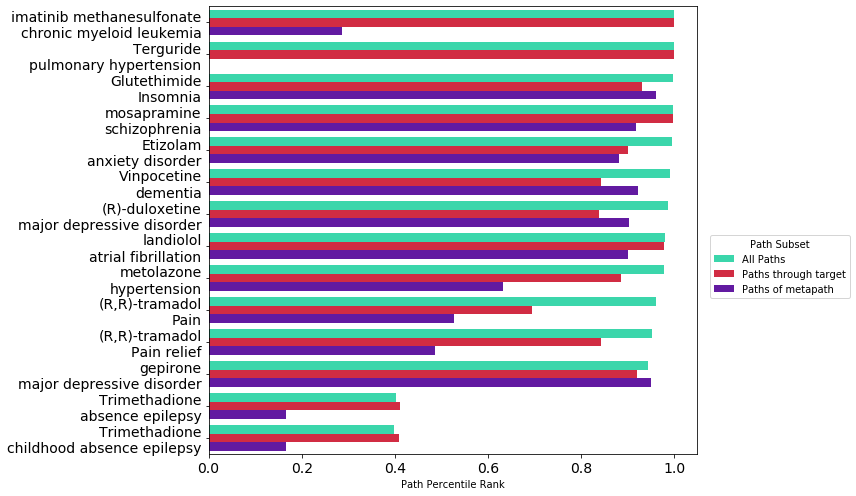

In [66]:
melt_plt_df = plt_df.melt(id_vars=['ind_name'], value_vars=['model_pct', 'tgt_pct', 'mp_pct'])

fig = plt.figure(figsize=(12, 7))
fig.set_tight_layout(True)
ax = sns.barplot(x='value', y='ind_name', hue='variable', data=melt_plt_df)

plt.ylabel('')
plt.xlabel('Path Percentile Rank')
plt.xticks(size=14)
plt.yticks(size=14)


h, l = ax.get_legend_handles_labels()
labels = ['All Paths', 'Paths through target', 'Paths of metapath']
ax.legend(h, labels, title="Path Subset", bbox_to_anchor=(1.015, .5));



In [67]:
new_plt_df = summary_df.dropna(subset=['metapath']).sort_values('model_pct', ascending=False).drop_duplicates(subset=['ind_name'])
new_melt_df = new_plt_df.melt(id_vars=['ind_name'], value_vars=['total_paths', 'tgt_paths', 'mp_paths'])


new_melt_df

ind_name     variable      value
0   imatinib methanesulfonate\nchronic myeloid leu...  total_paths  1236778.0
1                   Terguride\npulmonary hypertension  total_paths    16523.0
2                              Glutethimide\nInsomnia  total_paths    88253.0
3                          mosapramine\nschizophrenia  total_paths     4410.0
4                          Etizolam\nanxiety disorder  total_paths    42582.0
5                               Vinpocetine\ndementia  total_paths   291650.0
6           (R)-duloxetine\nmajor depressive disorder  total_paths    36692.0
7                      landiolol\natrial fibrillation  total_paths     1218.0
8                            metolazone\nhypertension  total_paths    13044.0
9                                (R,R)-tramadol\nPain  total_paths   172613.0
10                        (R,R)-tramadol\nPain relief  total_paths   294203.0
11                gepirone\nmajor depressive disorder  total_paths      603.0
12                    Trimethadione\nabsence epilepsy  total_paths      409.0
13          Trimethadione\nchildhood absence epilepsy  total_paths      362.0
14  imatinib methanesulfonate\nchronic myeloid leu...    tgt_paths     1165.0
15                  Terguride\npulmonary hypertension    tgt_paths     1104.0
16                             Glutethimide\nInsomnia    tgt_paths      143.0
17                         mosapramine\nschizophrenia    tgt_paths     1792.0
18                         Etizolam\nanxiety disorder    tgt_paths      280.0
19                              Vinpocetine\ndementia    tgt_paths      134.0
20          (R)-duloxetine\nmajor depressive disorder    tgt_paths      243.0
21                     landiolol\natrial fibrillation    tgt_paths     1005.0
22                           metolazone\nhypertension    tgt_paths      646.0
23                               (R,R)-tramadol\nPain    tgt_paths      951.0
24                        (R,R)-tramadol\nPain relief    tgt_paths     3450.0
25                gepirone\nmajor depressive disorder    tgt_paths      304.0
26                    Trimethadione\nabsence epilepsy    tgt_paths      141.0
27          Trimethadione\nchildhood absence epilepsy    tgt_paths      125.0
28  imatinib methanesulfonate\nchronic myeloid leu...     mp_paths        7.0
29                  Terguride\npulmonary hypertension     mp_paths        1.0
30                             Glutethimide\nInsomnia     mp_paths      368.0
31                         mosapramine\nschizophrenia     mp_paths       37.0
32                         Etizolam\nanxiety disorder     mp_paths      169.0
33                              Vinpocetine\ndementia     mp_paths      244.0
34          (R)-duloxetine\nmajor depressive disorder     mp_paths      451.0
35                     landiolol\natrial fibrillation     mp_paths       20.0
36                           metolazone\nhypertension     mp_paths       19.0
37                               (R,R)-tramadol\nPain     mp_paths     1036.0
38                        (R,R)-tramadol\nPain relief     mp_paths     1245.0
39                gepirone\nmajor depressive disorder     mp_paths       79.0
40                    Trimethadione\nabsence epilepsy     mp_paths       54.0
41          Trimethadione\nchildhood absence epilepsy     mp_paths       54.0

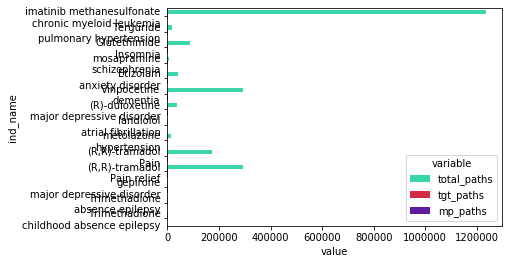

In [68]:
ax = sns.barplot(x='value', y='ind_name', hue='variable', data=new_melt_df)

In [69]:
# Choose custom node colors
node_color_map = {'AnatomicalEntity': '#5252b9',
                'BiologicalProcessOrActivity': '#fc99d5',
                'MacromolecularMachine': '#d032a3',
                'Disease': '#50e316',
                'Pathway': '#b7d165',
                'PhenotypicFeature': '#165f28',
                'GeneFamily': '#6404b7',
                'PhysiologicalProcess': '#ec102f',
                'OrganismTaxon': '#e9bf98',
                'ChemicalSubstance': '#21f0b6'}

node_id_to_color = nodes.set_index('id')['label'].map(node_color_map).to_dict()

import graph_plots as gp

def draw_top_paths(path_df, head_num=10, metric='model_metric', poi_idx=None, proba=None):


    if poi_idx is not None:
        path_of_interest = path_df.loc[poi_idx, 'node_ids']
    else:
        path_of_interest = []
        
    top_n_paths = path_df.sort_values(metric, ascending=False).head(head_num)

    # Get the list of paths
    list_of_paths = top_n_paths['node_ids'].tolist()
    path_weights = top_n_paths[metric].tolist()

    # Get the edge names
    list_of_edges = []
    for mp in top_n_paths['metapath']:
        list_of_edges.append(gp.parse_metapath_to_edge_names(mp, mp_info, inv_map))

    edge_color_map = gp.highlight_path_of_interest(list_of_paths, path_of_interest)

    G = gp.build_explanitory_graph(list_of_paths, list_of_edges, path_weights=path_weights, 
                                node_id_to_label=id_to_label, node_id_to_color=node_id_to_color, 
                                edge_id_to_color=edge_color_map)

    gp.draw_explanitory_graph(G, node_id_to_name=id_to_name, proba=proba, n_paths=len(list_of_paths));

## And plot the paths themselves

In [70]:
sns.set_palette(default_colors)

In [71]:
def graph_overall_pair(pair_num, n_paths=10):

    sub_sum_df = summary_df.dropna(subset=['overall_rank'])
    
    cid = sub_sum_df.iloc[pair_num].loc['chem_id']
    did = sub_sum_df.iloc[pair_num].loc['dis_id']

    this_path = path_res[(cid, did)]
    path_idx = sub_sum_df.iloc[pair_num].loc['overall_rank'].astype(int)-1
    
    prob = dmdb_pairs.query('chemicalsubstance_id == @cid and disease_id == @did')['proba'].values[0]
    draw_top_paths(this_path, n_paths, poi_idx=path_idx, proba=prob)


In [72]:
summary_df.dropna(subset=['overall_rank']).reset_index(drop=True)

chem_name                    dis_name       chem_id  \
0   imatinib methanesulfonate    chronic myeloid leukemia   CHEBI:31690   
1   imatinib methanesulfonate    chronic myeloid leukemia   CHEBI:31690   
2              (R)-duloxetine   major depressive disorder   CHEBI:36797   
3              (R)-duloxetine   major depressive disorder   CHEBI:36797   
4                   Terguride      pulmonary hypertension   CHEBI:32193   
5                   Terguride      pulmonary hypertension   CHEBI:32193   
6                   landiolol         atrial fibrillation  CHEBI:135809   
7                   landiolol         atrial fibrillation  CHEBI:135809   
8                 mosapramine               schizophrenia  CHEBI:135775   
9                 mosapramine               schizophrenia  CHEBI:135775   
10                 metolazone                hypertension   CHEBI:64354   
11                 metolazone                hypertension   CHEBI:64354   
12                   gepirone   major depressive disorder  CHEBI:135990   
13                   gepirone   major depressive disorder  CHEBI:135990   
14             (R,R)-tramadol                 Pain relief   CHEBI:75725   
15             (R,R)-tramadol                 Pain relief   CHEBI:75725   
16             (R,R)-tramadol                        Pain   CHEBI:75725   
17             (R,R)-tramadol                        Pain   CHEBI:75725   
18              Trimethadione  childhood absence epilepsy    CHEBI:9727   
19              Trimethadione  childhood absence epilepsy    CHEBI:9727   
20              Trimethadione            absence epilepsy    CHEBI:9727   
21              Trimethadione            absence epilepsy    CHEBI:9727   
22                   Etizolam            anxiety disorder   CHEBI:31583   
23                   Etizolam            anxiety disorder   CHEBI:31583   
24                Vinpocetine                    dementia   CHEBI:77733   
25               Glutethimide                    Insomnia    CHEBI:5439   
26               Glutethimide                    Insomnia    CHEBI:5439   

          dis_id  treat_prob  model_metric     metapath  overall_rank  \
0      DOID:8552    0.343985      0.116835       CafGmD          23.0   
1      DOID:8552    0.343985      0.104654       CinGmD          30.0   
2      DOID:1470    0.577926      0.003531  CafGpoBPawD         458.0   
3      DOID:1470    0.577926      0.002549  CinGpoBPawD         583.0   
4      DOID:6432    0.287274      0.962788       CafGmD           1.0   
5      DOID:6432    0.287274      0.520344       CinGmD           2.0   
6   DOID:0060224    0.093310      0.082517  CafGpoBPawD          25.0   
7   DOID:0060224    0.093310      0.028727  CinGpoBPawD          69.0   
8      DOID:5419    0.085941      0.114002  CinGpoPWawD          15.0   
9      DOID:5419    0.085941      0.076494  CafGpoPWawD          19.0   
10    DOID:10763    0.119678      0.004374  CinGpoBPawD         296.0   
11    DOID:10763    0.119678      0.003785  CafGpoBPawD         325.0   
12     DOID:1470    0.049190      0.023009  CafGpoBPawD          34.0   
13     DOID:1470    0.049190      0.007986   CaGpoBPawD         102.0   
14    DOID:60164    0.603647      0.000082  CafGpoBPawD       13787.0   
15    DOID:60164    0.603647      0.000028   CaGpoBPawD       24382.0   
16    DOID:60145    0.629704      0.000142  CafGpoBPawD        6822.0   
17    DOID:60145    0.629704      0.000042   CaGpoBPawD       11261.0   
18     DOID:1825    0.151561      0.000476  CafGpoBPawD         218.0   
19     DOID:1825    0.151561      0.000262  CinGpoBPawD         244.0   
20  DOID:0070309    0.087817      0.000475  CafGpoBPawD         244.0   
21  DOID:0070309    0.087817      0.000260  CinGpoBPawD         287.0   
22     DOID:2030    0.235498      0.011142  CafGpoBPawD         210.0   
23     DOID:2030    0.235498      0.004118   CaGpoBPawD         428.0   
24     DOID:1307    0.040116      0.000517   CinGpoAawD        2612.0   
25    DOID:50433    0

In [73]:
def graph_mp_pair(pair_num, n_paths=10):

    sub_sum_df = summary_df.dropna(subset=['overall_rank'])
    
    cid = sub_sum_df.iloc[pair_num].loc['chem_id']
    did = sub_sum_df.iloc[pair_num].loc['dis_id']
    path_idx = sub_sum_df.iloc[pair_num].loc['overall_rank'].astype(int)-1

    this_path = path_res[(cid, did)]
    poi = this_path.loc[path_idx, 'nodes']
    
    this_path['nt'] = this_path['nodes'].apply(tuple)
    poi_t = tuple(poi)
    
    mps = this_path.query('nt == @poi_t')['metapath'].unique()
    mp_path = this_path.query('metapath in @mps')
    
    prob = dmdb_pairs.query('chemicalsubstance_id == @cid and disease_id == @did')['proba'].values[0]
    draw_top_paths(mp_path, n_paths, poi_idx=path_idx, proba=prob)


In [74]:
def graph_tgt_pair(pair_num, n_paths=10):

    sub_sum_df = summary_df.dropna(subset=['overall_rank'])
    
    cid = sub_sum_df.iloc[pair_num].loc['chem_id']
    did = sub_sum_df.iloc[pair_num].loc['dis_id']
    path_idx = sub_sum_df.iloc[pair_num].loc['overall_rank'].astype(int)-1

    this_path = path_res[(cid, did)]
    poi = this_path.loc[path_idx, 'nodes']

    tgt = this_path.loc[path_idx, 'node_ids'][1]
    tgt_df = query_target(this_path, tgt)
    
    prob = dmdb_pairs.query('chemicalsubstance_id == @cid and disease_id == @did')['proba'].values[0]
    draw_top_paths(tgt_df, n_paths, poi_idx=path_idx, proba=prob)


In [75]:
sns.set_palette('muted')

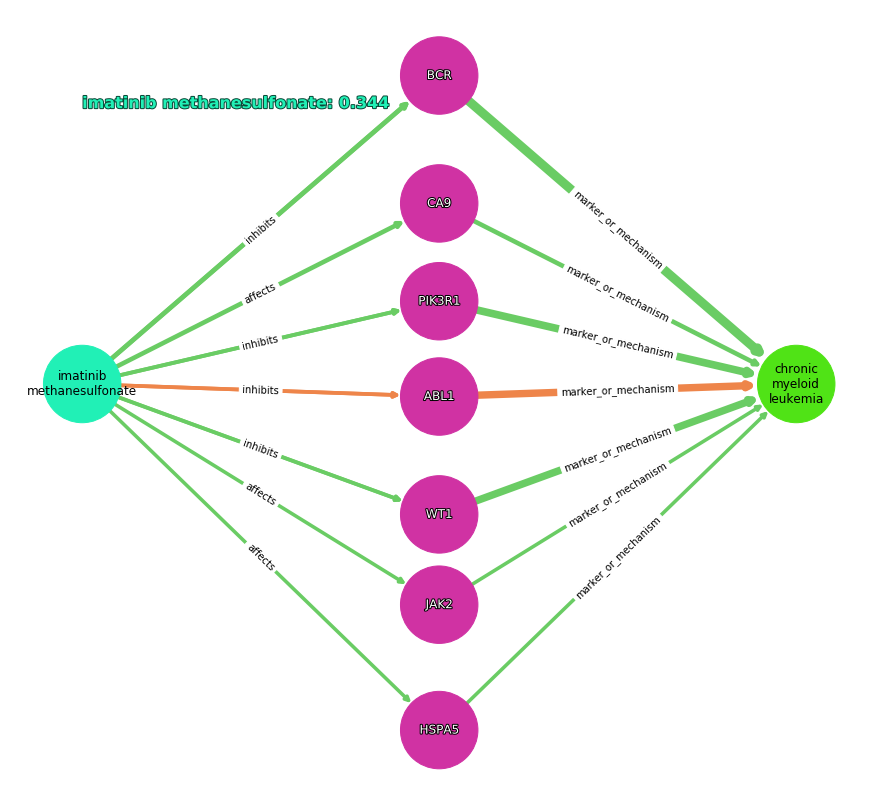

In [76]:
graph_mp_pair(0, 20)

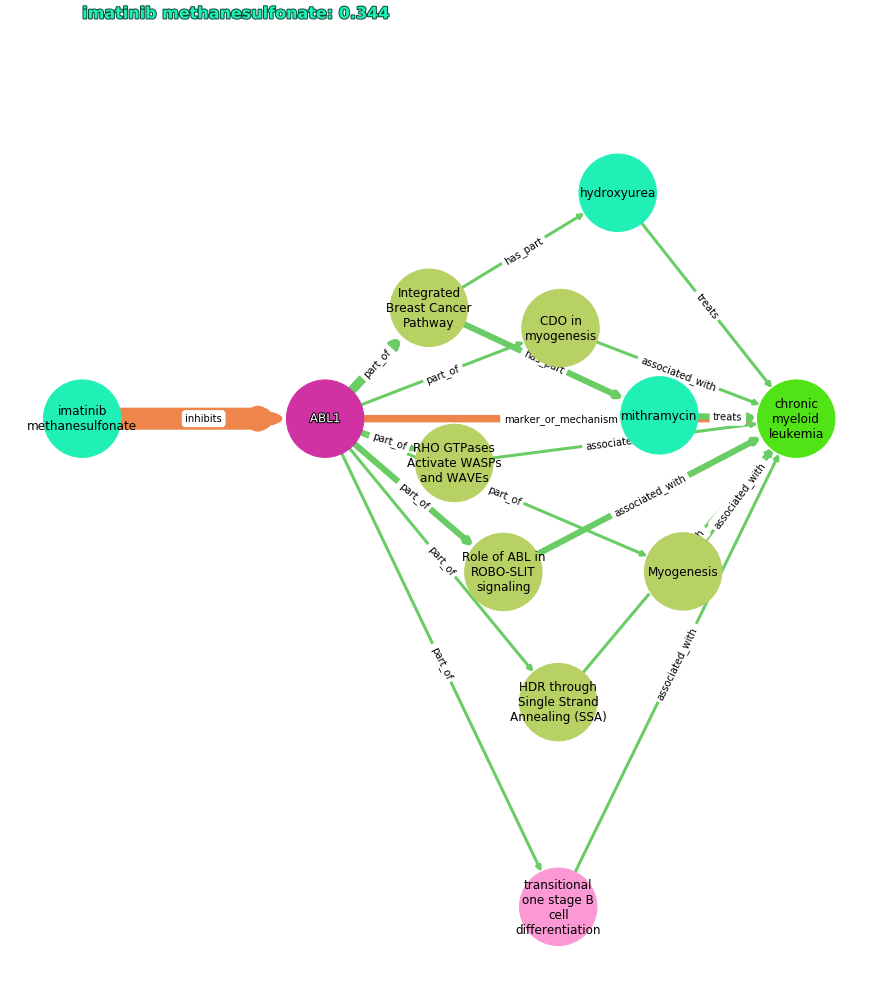

In [77]:
graph_tgt_pair(0, 12)

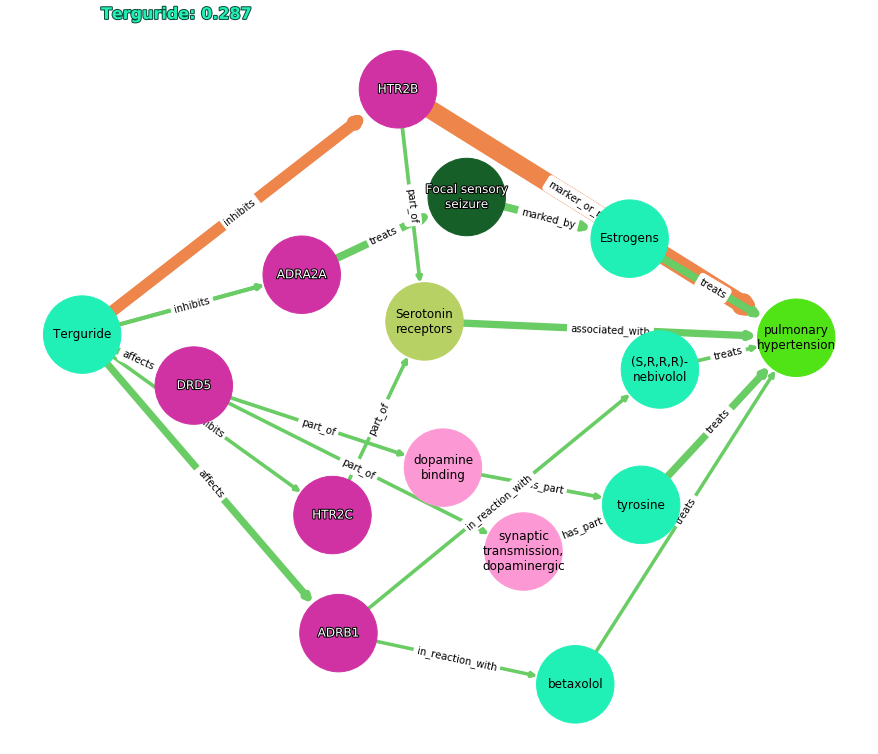

In [82]:
graph_overall_pair(3, 10)

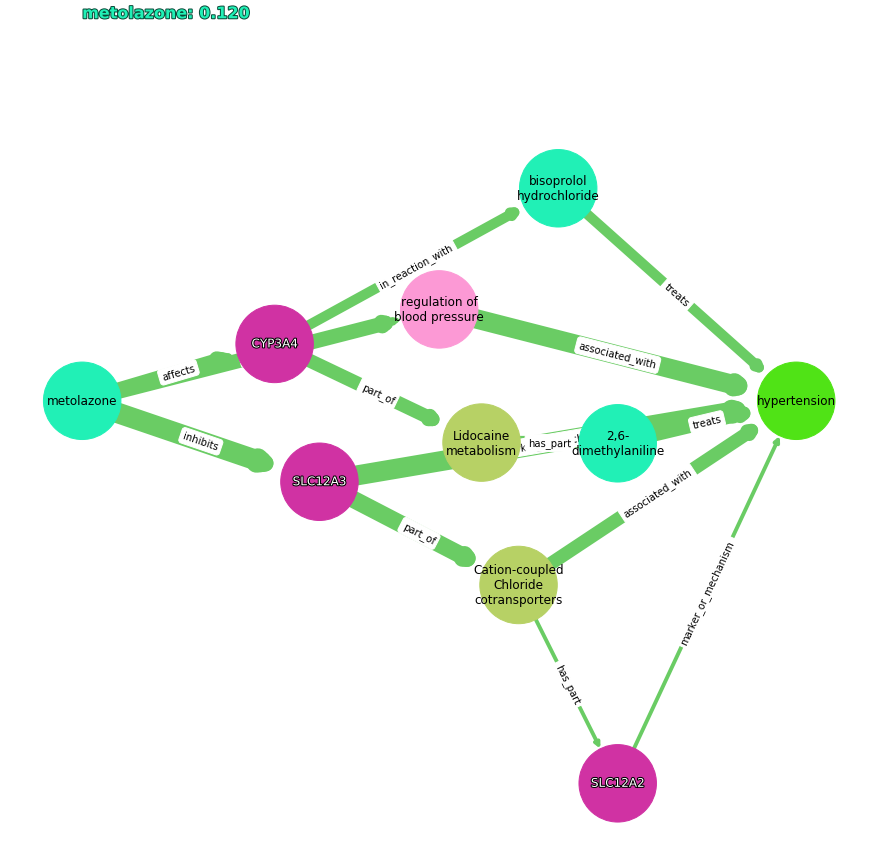

In [83]:
graph_overall_pair(6, 10)

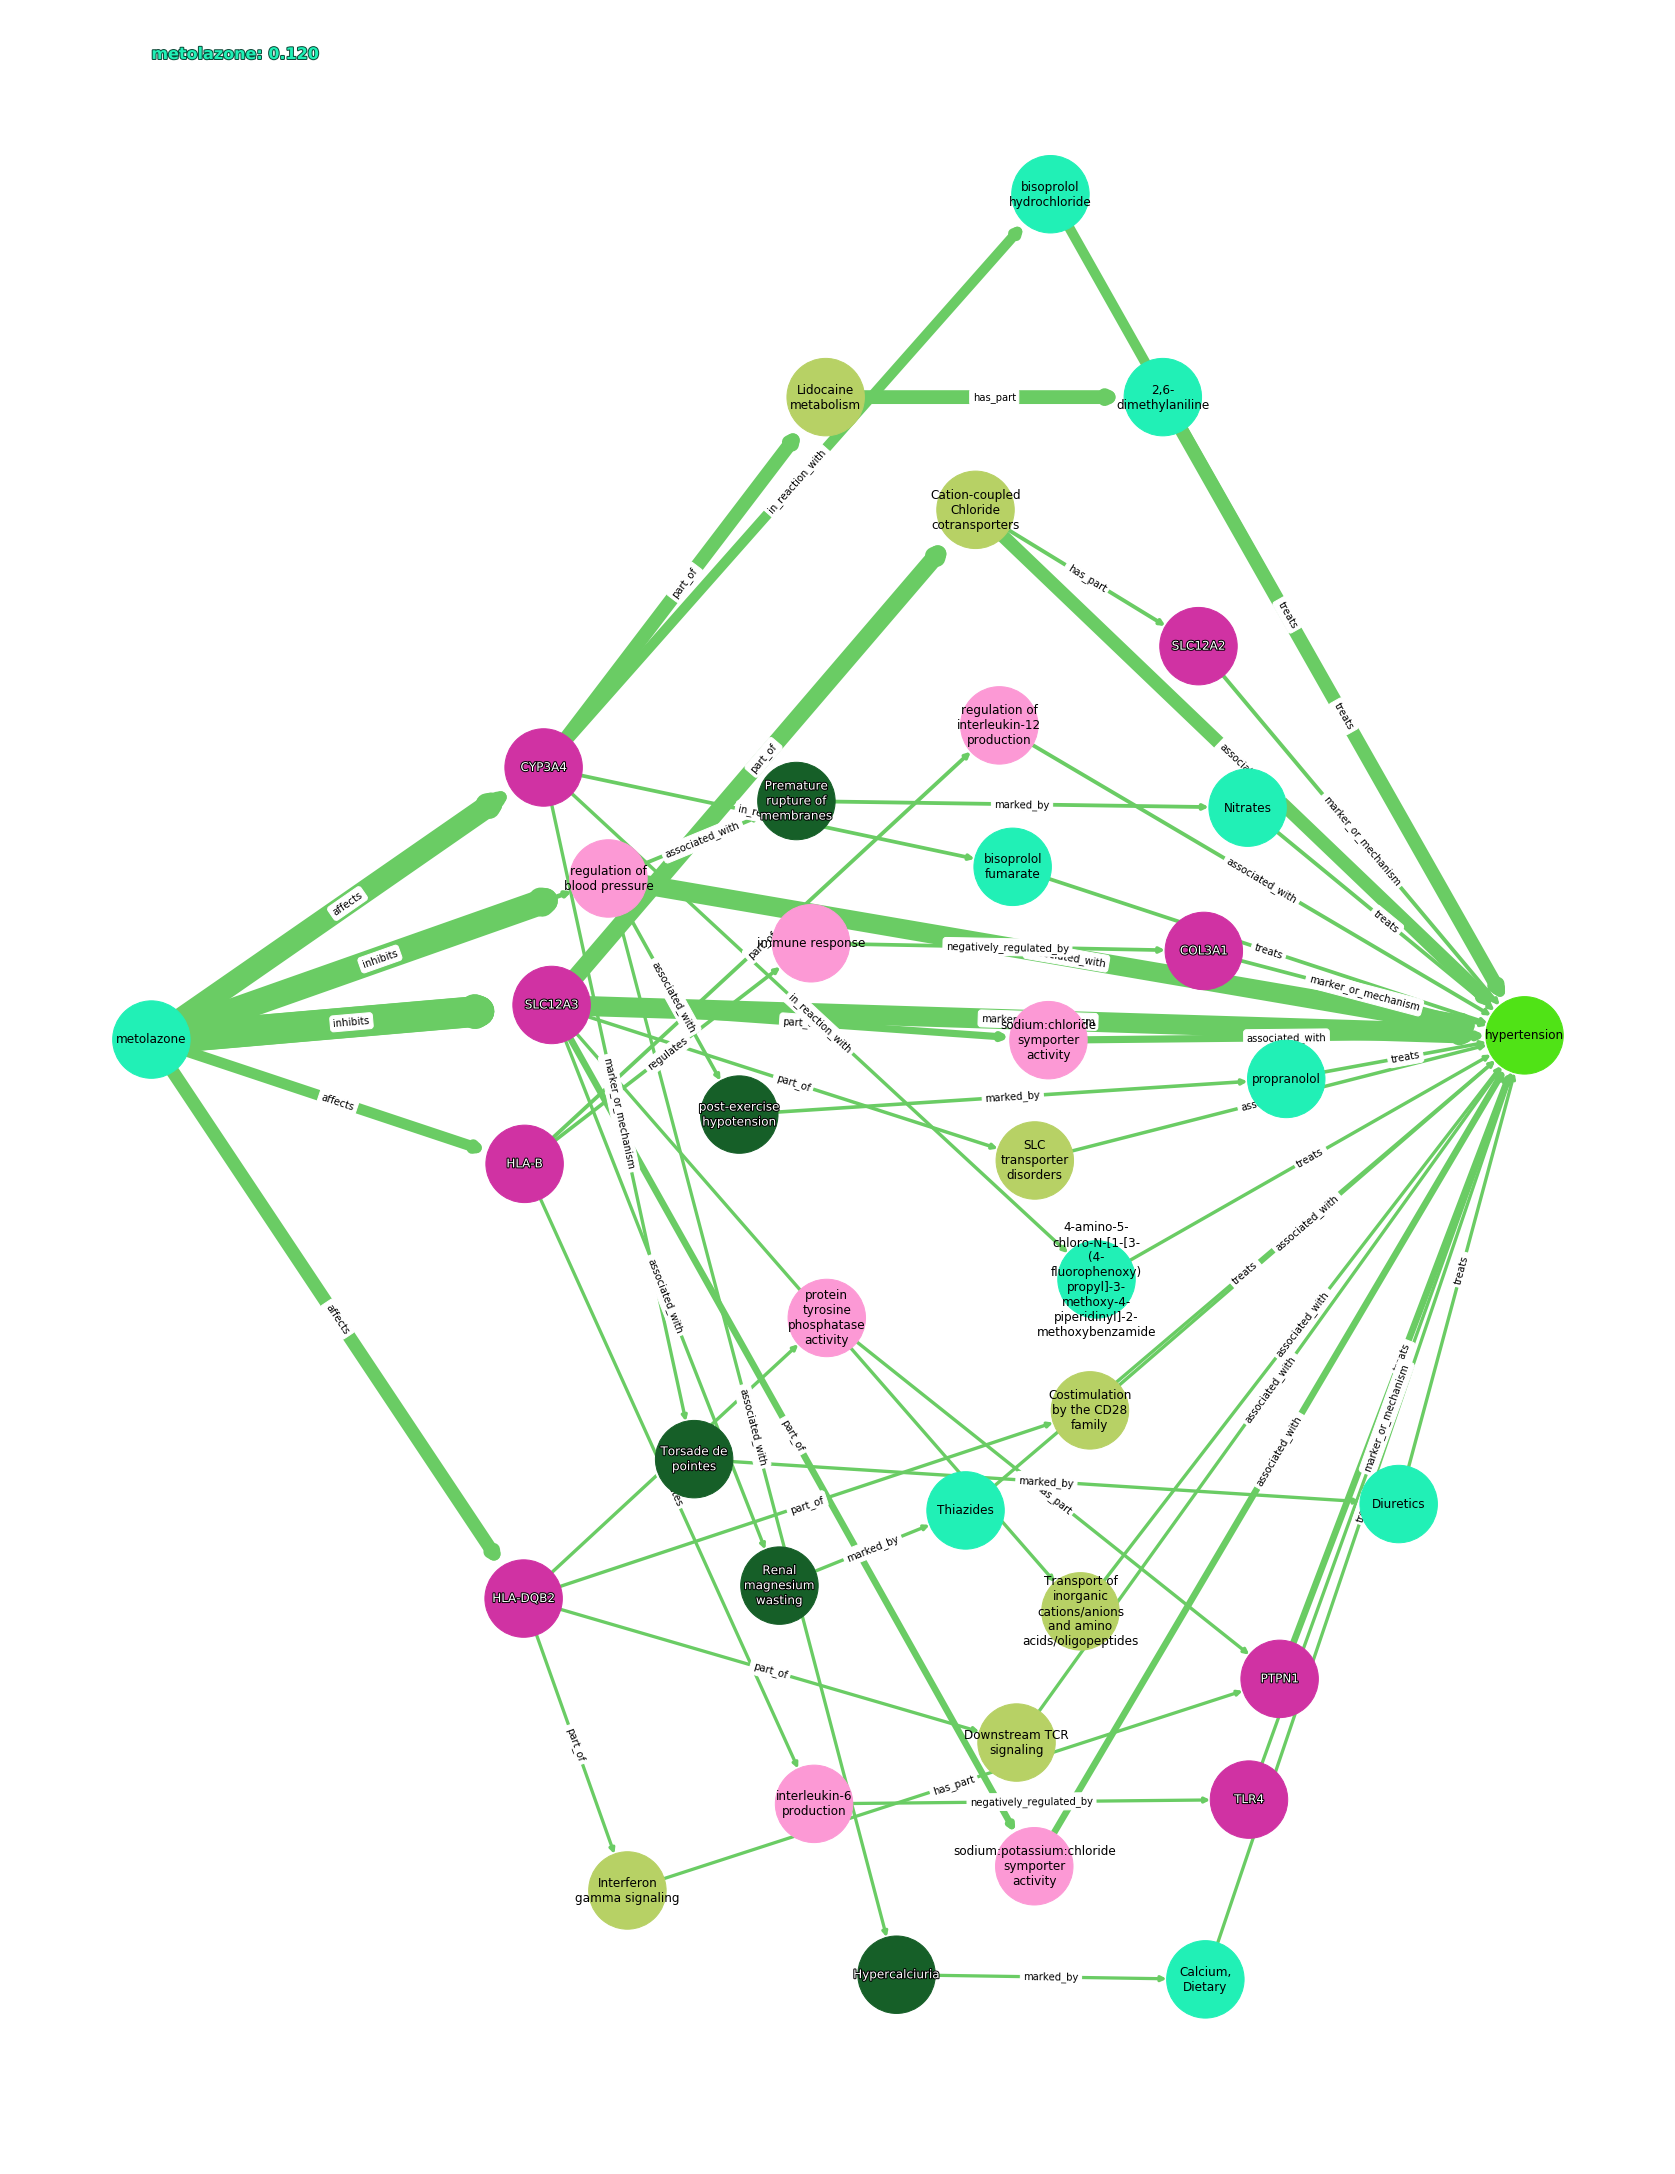

In [84]:
graph_overall_pair(7, 30)

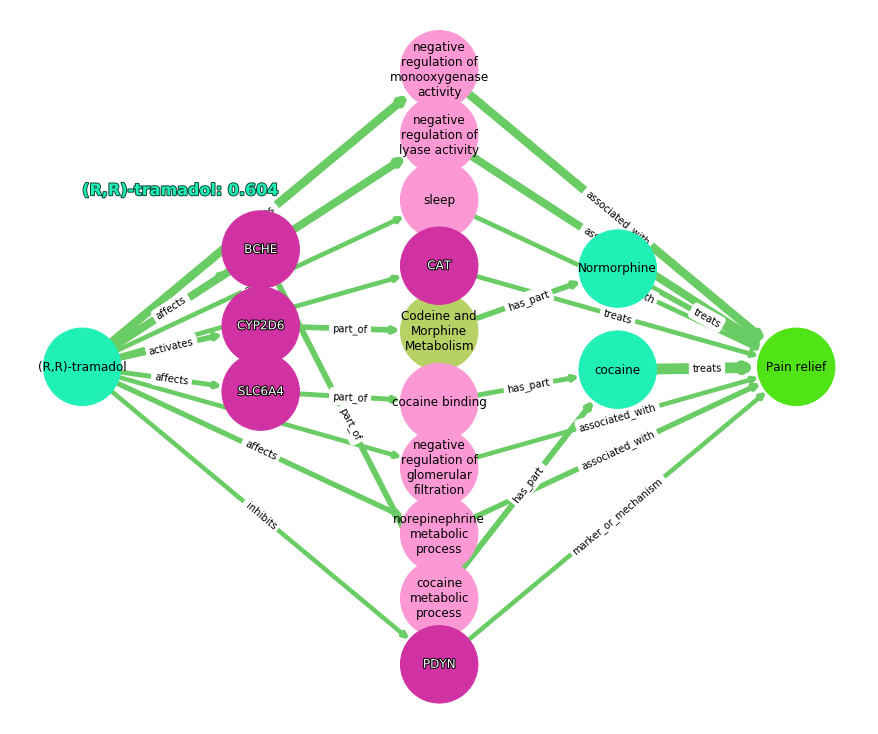

In [85]:
graph_overall_pair(8, 10)

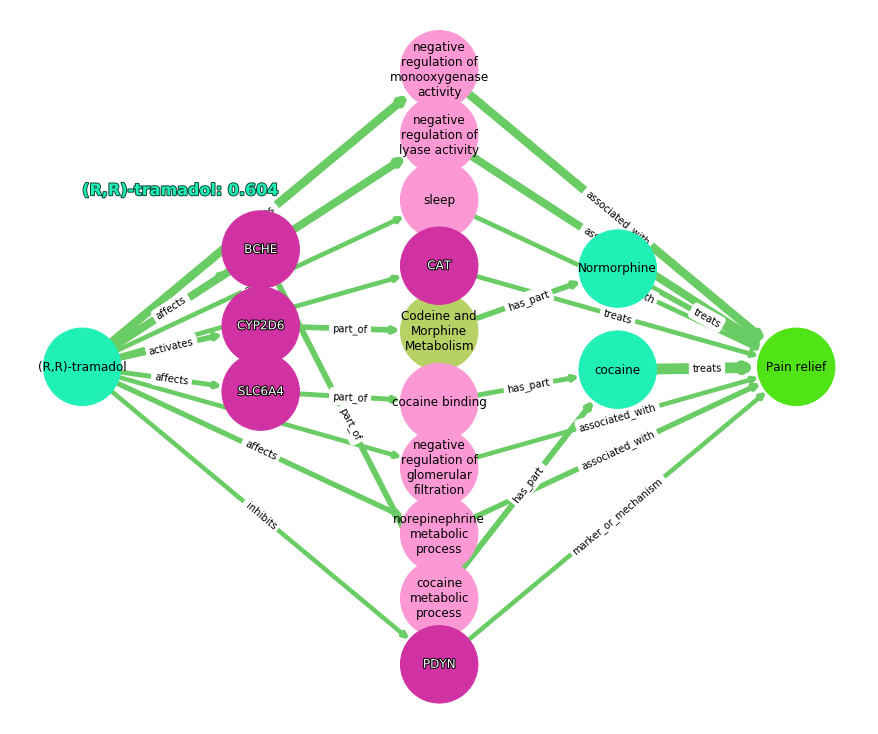

In [86]:
graph_overall_pair(9, 10)

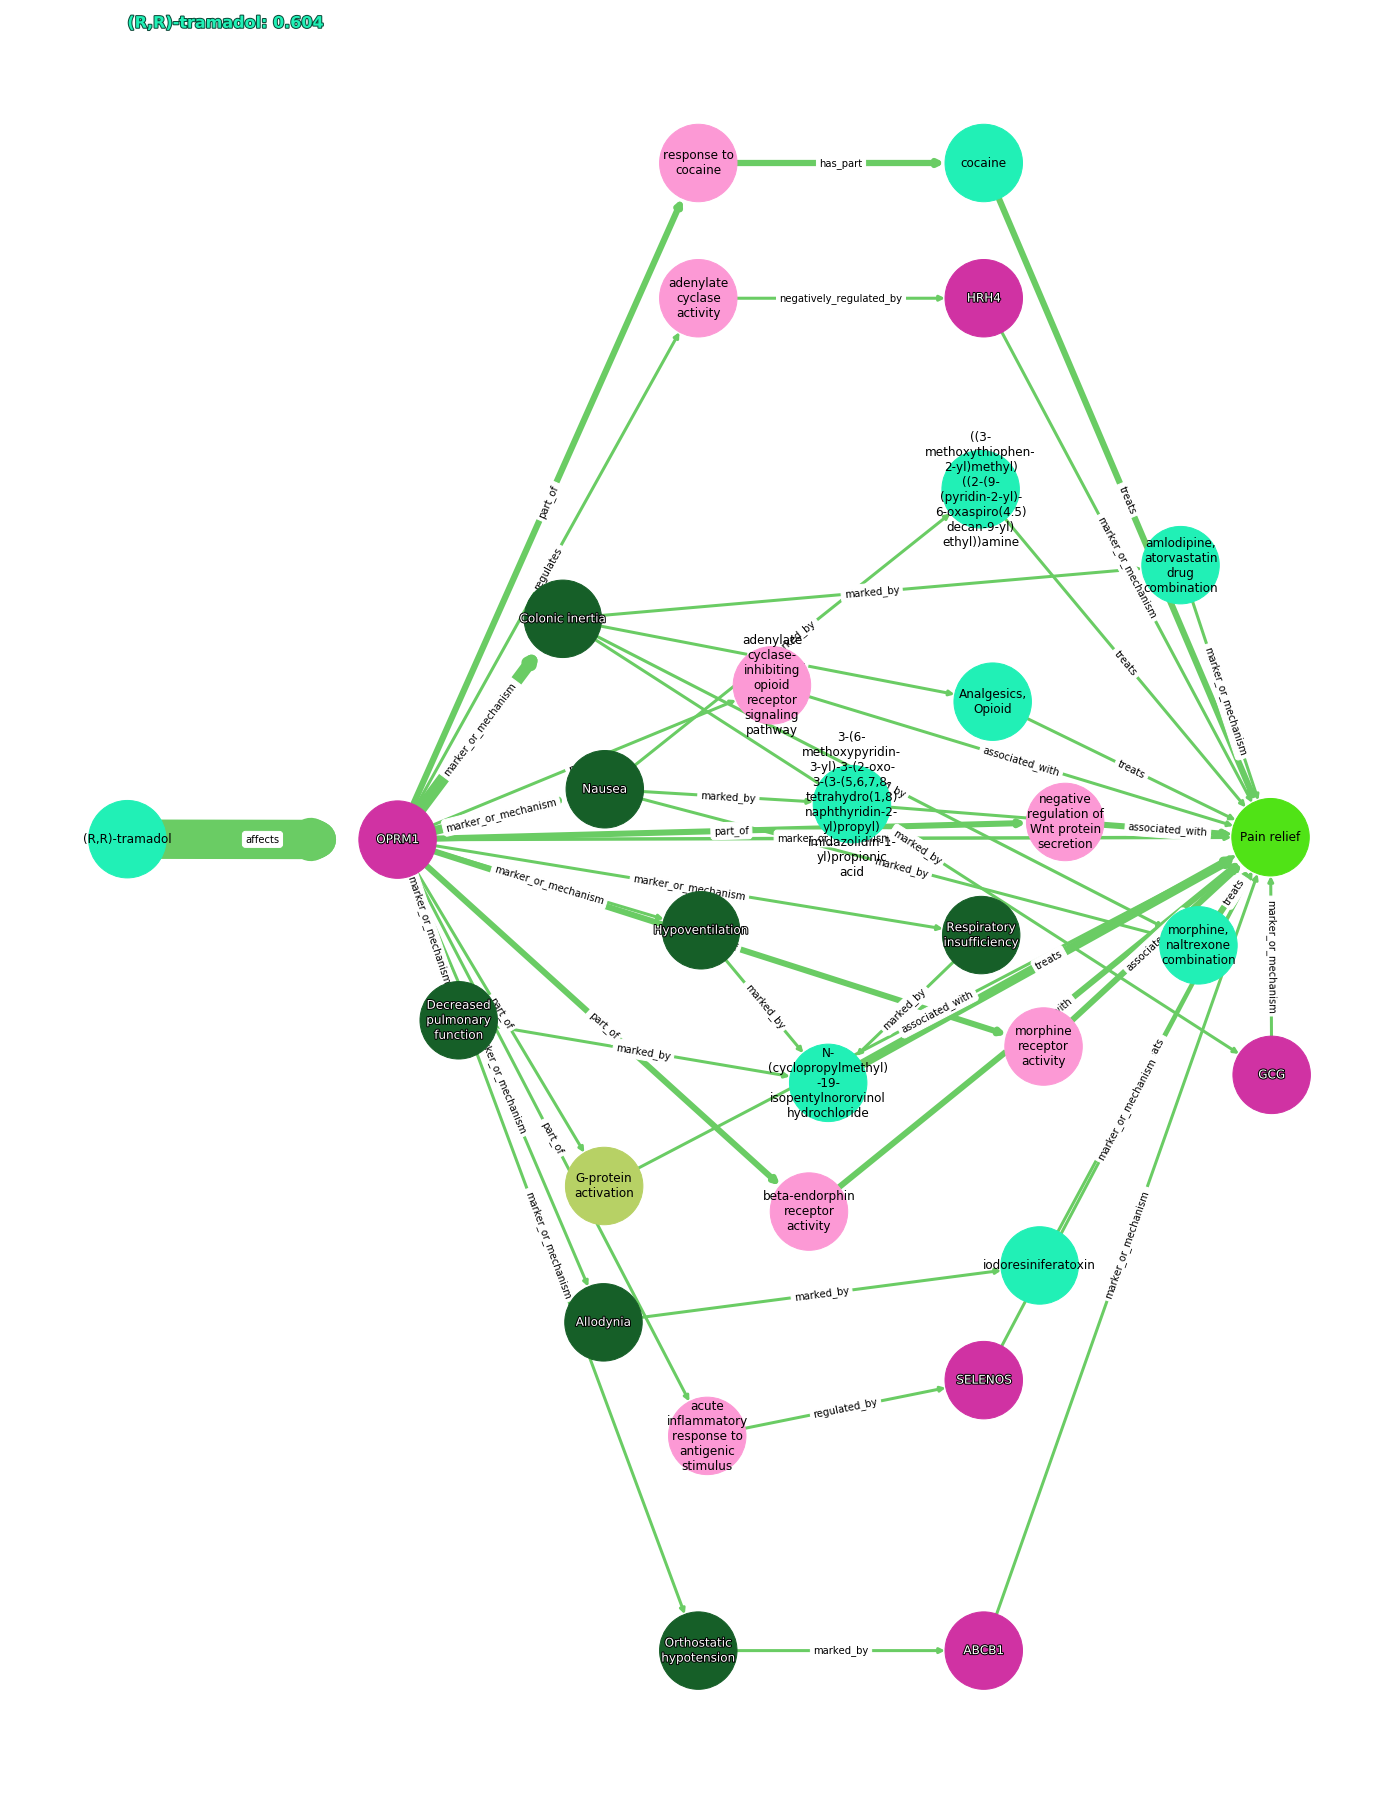

In [87]:
graph_tgt_pair(9, 25)

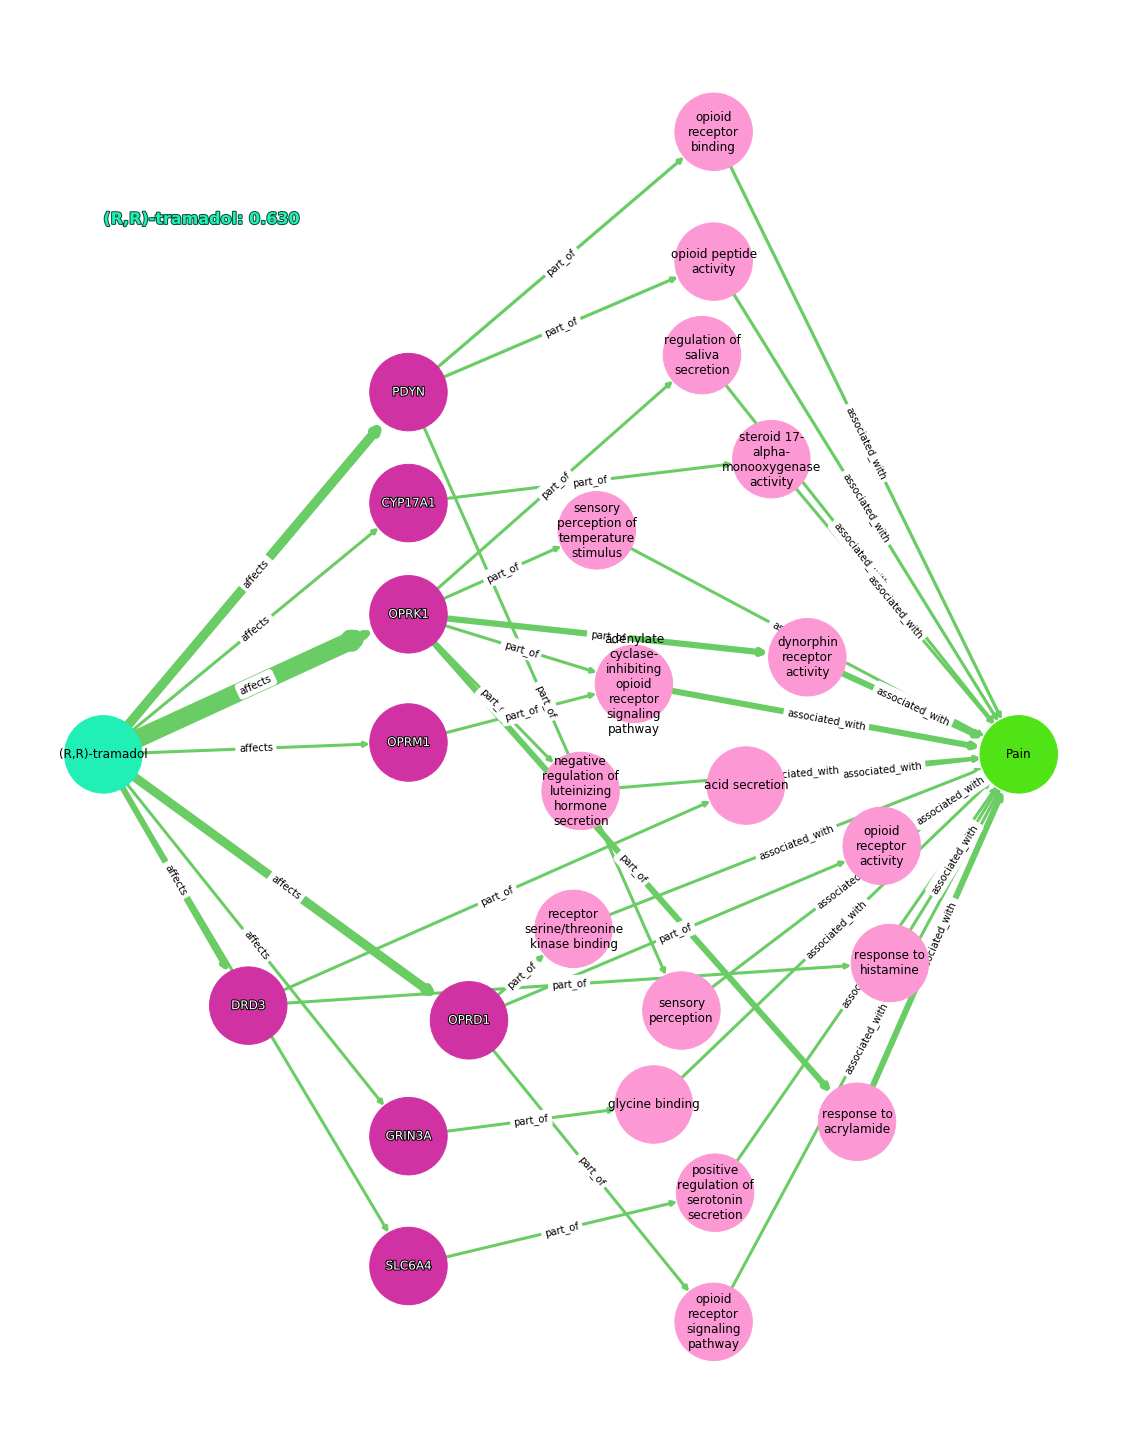

In [88]:
graph_mp_pair(10, 20)

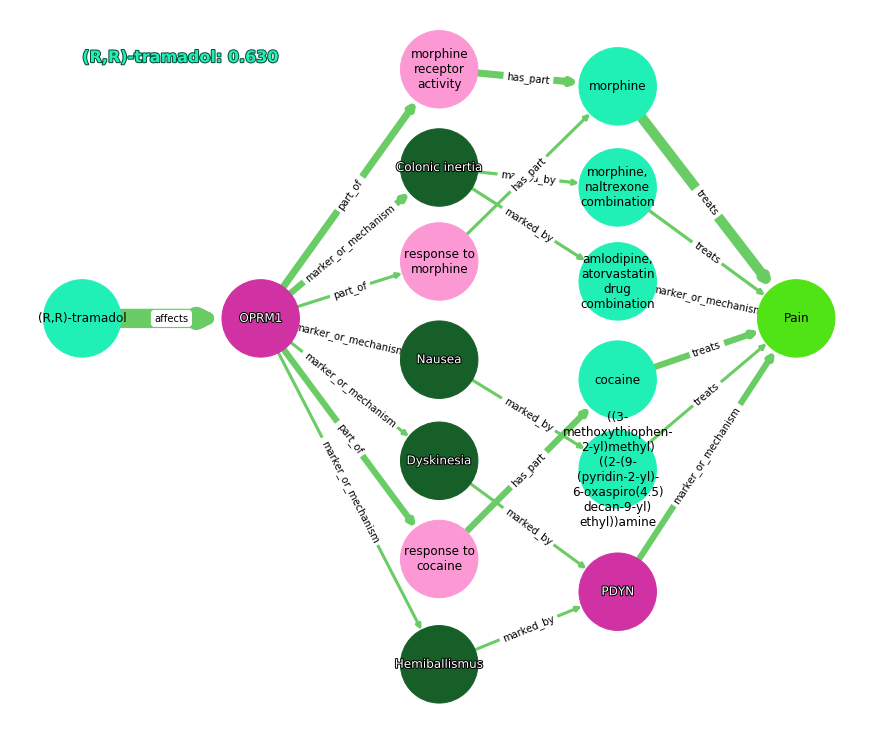

In [89]:
graph_tgt_pair(10, 10)

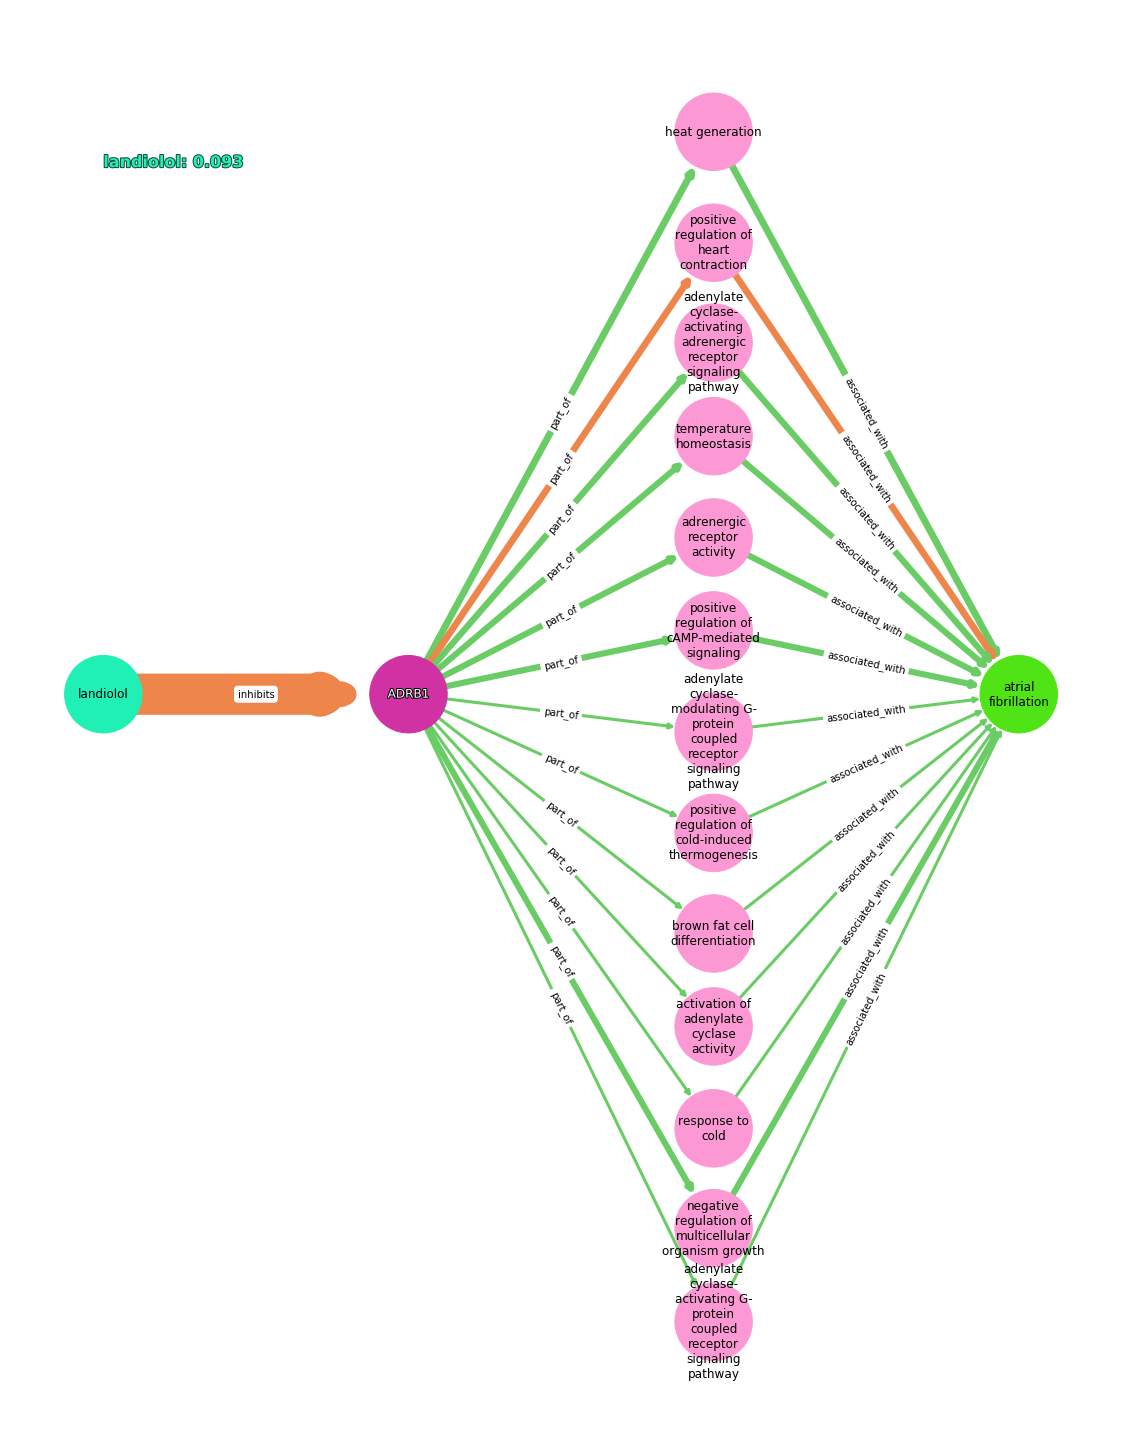

In [90]:
graph_mp_pair(5, 20)

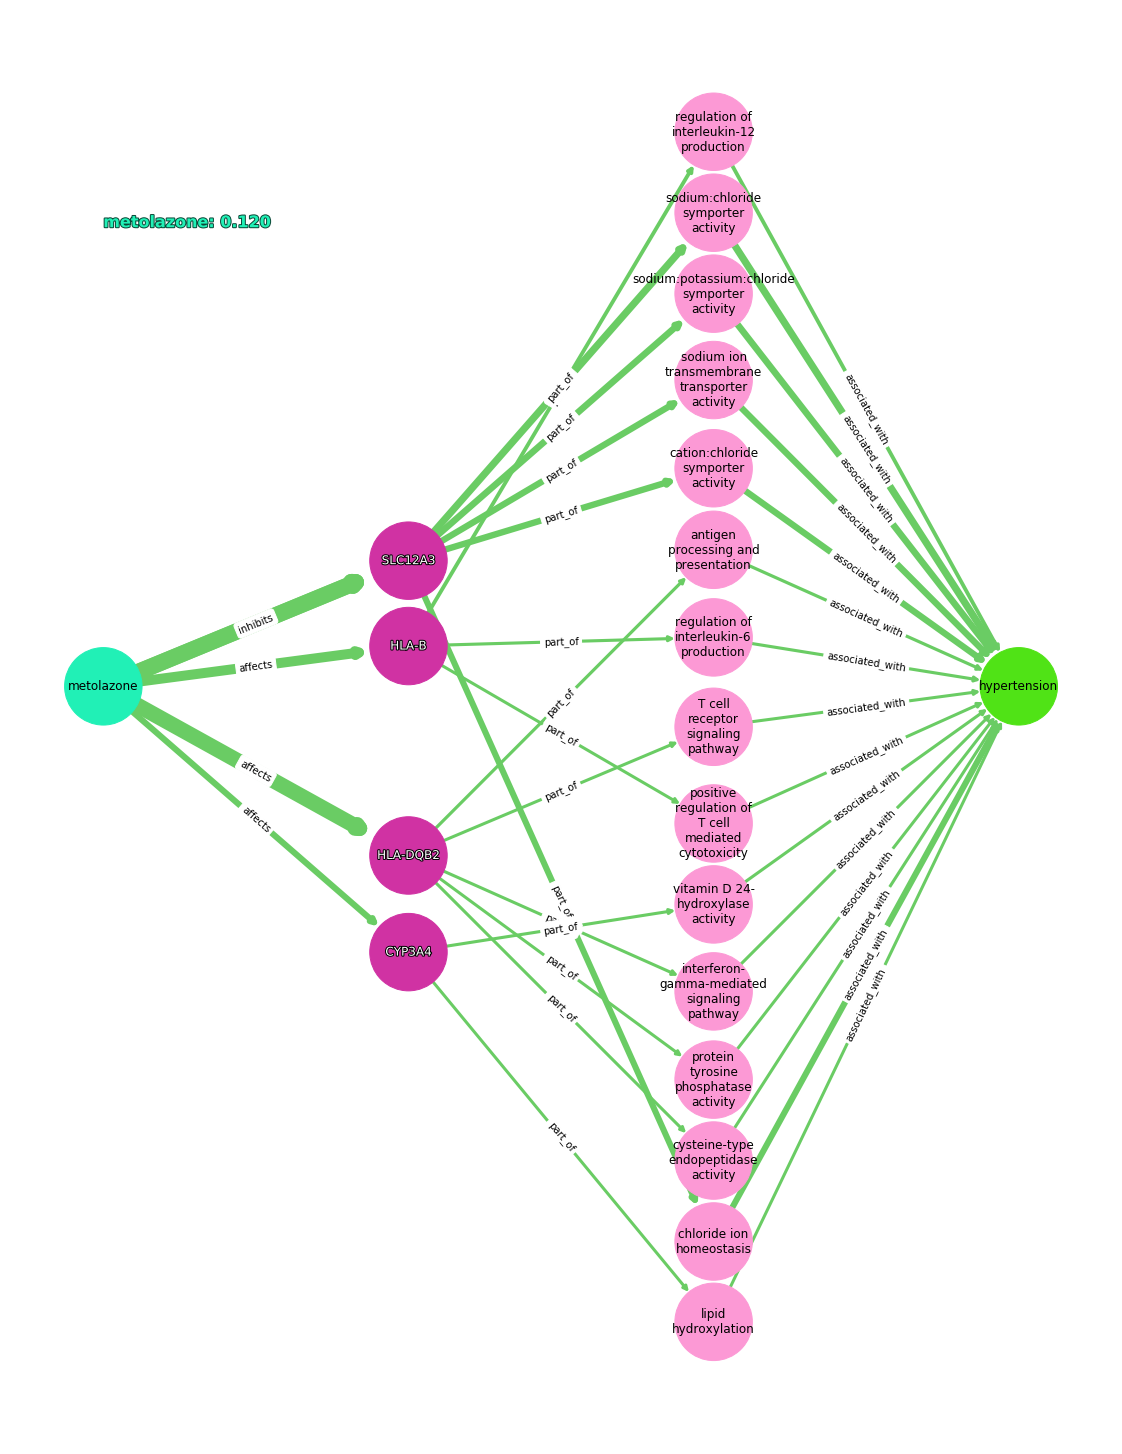

In [91]:
graph_mp_pair(6, 20)

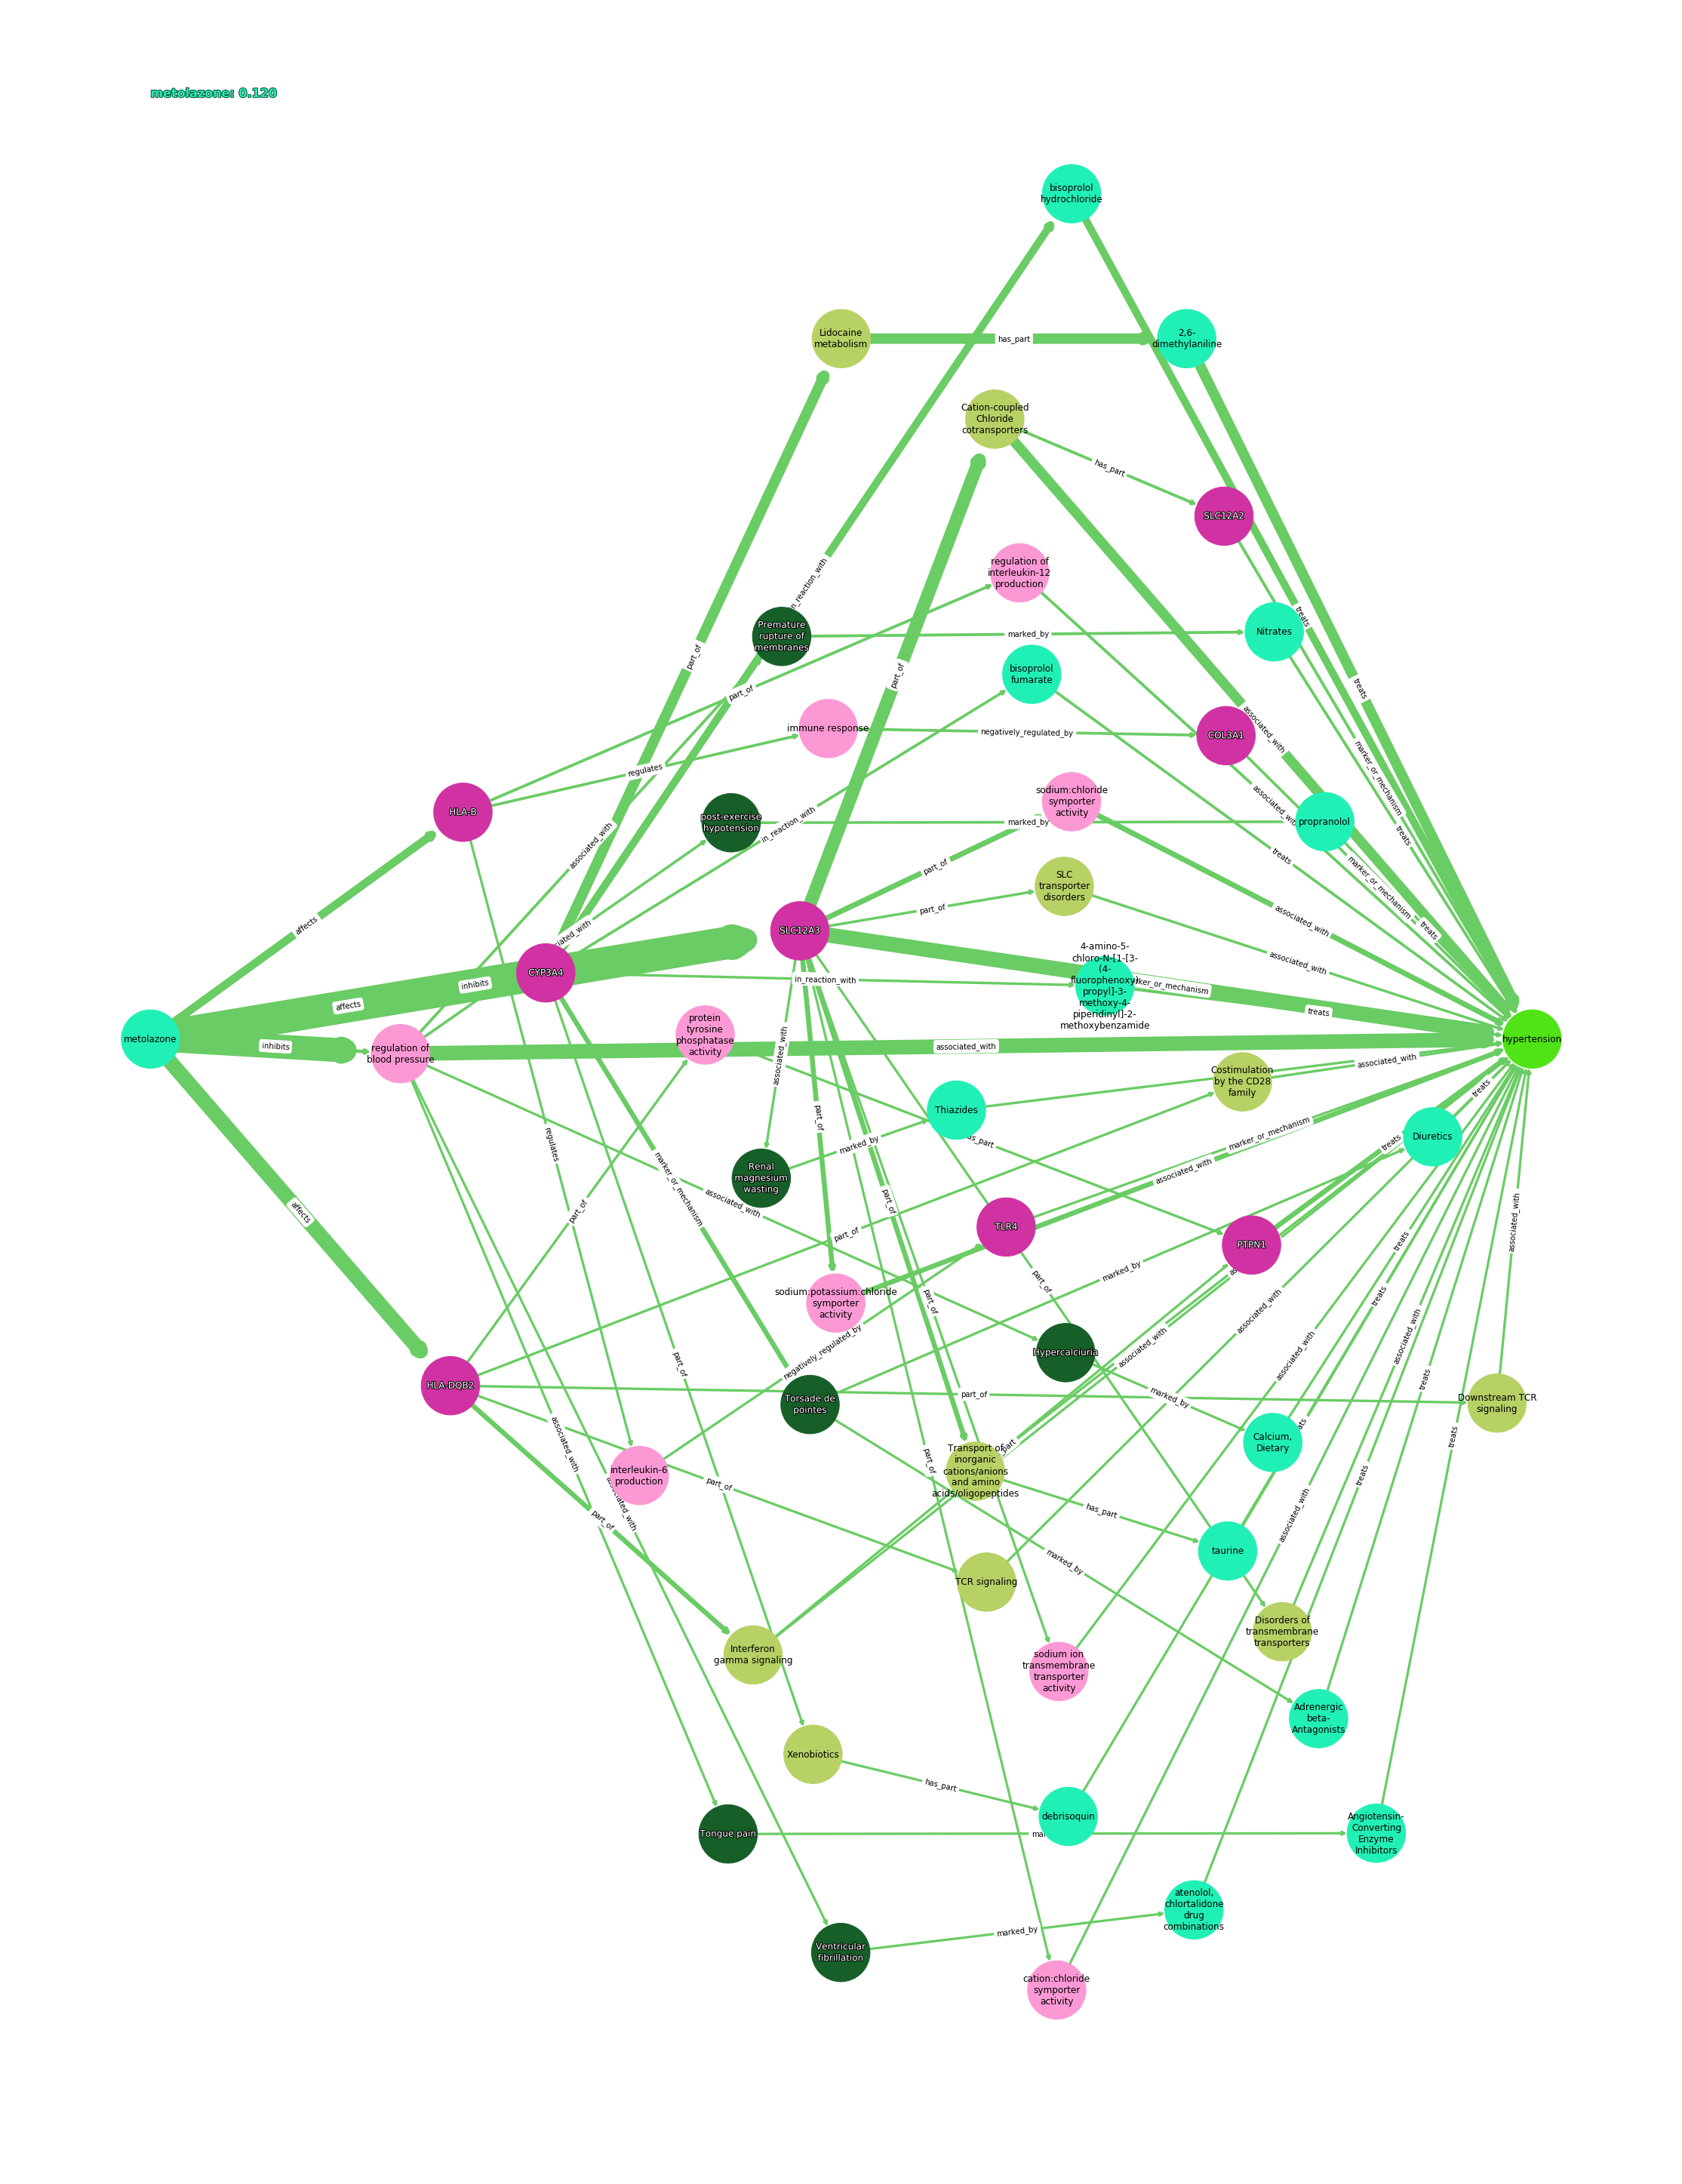

In [92]:
graph_overall_pair(6, 40)

# Path node rankings 

In [93]:
pair_num = 0

sub_sum_df = summary_df.dropna(subset=['overall_rank'])

cid = sub_sum_df.iloc[pair_num].loc['chem_id']
did = sub_sum_df.iloc[pair_num].loc['dis_id']

this_path = path_res[(cid, did)]

In [94]:
id_to_name[cid], id_to_name[did]

('imatinib methanesulfonate', 'chronic myeloid leukemia')

In [95]:
from data_tools import df_processing as dfp

In [96]:
"""
    separate_node_position=False
   
    if separate_node_position:
        # Group on the nodes and add the metrics
        node_metrics = all_nodes.groupby(['node_ids', 'deg_sep'])[metric].sum()

"""

"\n    separate_node_position=False\n   \n    if separate_node_position:\n        # Group on the nodes and add the metrics\n        node_metrics = all_nodes.groupby(['node_ids', 'deg_sep'])[metric].sum()\n\n"

In [97]:
def rank_connecting_nodes(path_df, metric='model_metric'):
    
    first_path = path_df.iloc[0, 0]
    comp_id = first_path[0]
    dis_id = first_path[-1]
    
    metric_vals = path_df[[metric]].reset_index()
    
    # Expand all the nodes
    all_nodes = dfp.expand_split_col(path_df['node_ids'])
    
    # Get the index of each node in the list (this is essential degrees of separation)
    deg_sep = path_df['nodes'].apply(lambda x: list(range(len(x)))).rename('deg_sep')
    deg_sep = dfp.expand_split_col(deg_sep).drop('old_idx', axis=1)
    all_nodes = pd.concat([all_nodes, deg_sep], axis=1)
    
    # Add in each metric for each instance of a node
    all_nodes = all_nodes.merge(metric_vals, left_on=['old_idx'], right_on=['index']).drop(['index', 'old_idx'], axis=1)
    
        
    # Group on the nodes and add the metrics
    node_metrics = all_nodes.groupby('node_ids')[metric].sum()
    # Get the minimum degress of separation
    deg_sep = all_nodes.groupby('node_ids')['deg_sep'].min()
    
    # Rejoin the metrics and degress of separation and sort.
    all_nodes = pd.concat([node_metrics, deg_sep], axis=1).reset_index().sort_values(metric, ascending=False)
    
    # Filter out the original compound and disease
    all_nodes = all_nodes.query('node_ids != @comp_id and node_ids != @dis_id').reset_index(drop=True)
    all_nodes['node_name'] = all_nodes['node_ids'].map(id_to_name)
    all_nodes['node_label'] = all_nodes['node_ids'].map(id_to_label)
    
    return all_nodes.rename(columns={'node_ids': 'node_id'})

In [98]:
test_ranks = rank_connecting_nodes(this_path)

In [99]:
test_ranks.head(20)

node_id  model_metric  deg_sep  \
0     CHEBI:17815      2.895868        2   
1    NCBIGene:613      1.265489        1   
2      GO:0036119      1.189846        1   
3   NCBIGene:1432      1.070619        1   
4       WP:WP4255      0.786427        2   
5      CHEBI:5626      0.785832        3   
6   NCBIGene:3717      0.770171        1   
7     NCBIGene:25      0.612255        1   
8    MESH:D016898      0.601874        3   
9      GO:0004743      0.557325        1   
10     GO:0070640      0.533884        1   
11  NCBIGene:6850      0.515380        1   
12  NCBIGene:5295      0.491062        1   
13   NCBIGene:768      0.488410        1   
14     HP:0011947      0.476853        2   
15   MESH:D001152      0.476853        3   
16     GO:0014827      0.445304        1   
17     GO:0043306      0.411361        1   
18     GO:0061909      0.401104        1   
19     GO:0004674      0.401081        2   

                                         node_name  \
0                           1,2-diacyl-sn-glycerol   
1                                              BCR   
2       response to platelet-derived growth factor   
3                                           MAPK14   
4                       Non-small cell lung cancer   
5                                    Harringtonine   
6                                             JAK2   
7                                             ABL1   
8                                 Interferon-alpha   
9                         pyruvate kinase activity   
10                    vitamin D3 metabolic process   
11                                             SYK   
12                                          PIK3R1   
13                                             CA9   
14                     Respiratory tract infection   
15                                      Arsenicals   
16             intestine smooth muscle contraction   
17  positive regulation of mast cell degranulation   
18                   autophagosome-lysosome fusion   
19        protein serine/threonine kinase activity   

                     node_label  
0             ChemicalSubstance  
1         MacromolecularMachine  
2   BiologicalProcessOrActivity  
3         MacromolecularMachine  
4                       Pathway  
5             ChemicalSubstance  
6         MacromolecularMachine  
7         MacromolecularMachine  
8             ChemicalSubstance  
9   BiologicalProcessOrActivity  
10  BiologicalProcessOrActivity  
11        MacromolecularMachine  
12        MacromolecularMachine  
13        MacromolecularMachine  
14            PhenotypicFeature  
15            ChemicalSubstance  
16  BiologicalProcessOrActivity  
17  BiologicalProcessOrActivity  
18  BiologicalProcessOrActivity  
19  BiologicalProcessOrActivity

In [100]:
test_ranks.query('node_label == "MacromolecularMachine" and deg_sep == 1').head(20)

node_id  model_metric  deg_sep node_name             node_label
1    NCBIGene:613      1.265489        1       BCR  MacromolecularMachine
3   NCBIGene:1432      1.070619        1    MAPK14  MacromolecularMachine
6   NCBIGene:3717      0.770171        1      JAK2  MacromolecularMachine
7     NCBIGene:25      0.612255        1      ABL1  MacromolecularMachine
11  NCBIGene:6850      0.515380        1       SYK  MacromolecularMachine
12  NCBIGene:5295      0.491062        1    PIK3R1  MacromolecularMachine
13   NCBIGene:768      0.488410        1       CA9  MacromolecularMachine
21  NCBIGene:7490      0.378495        1       WT1  MacromolecularMachine
26  NCBIGene:8454      0.328475        1      CUL1  MacromolecularMachine
32  NCBIGene:1021      0.226376        1      CDK6  MacromolecularMachine
33  NCBIGene:3309      0.219515        1     HSPA5  MacromolecularMachine
34   NCBIGene:332      0.219386        1     BIRC5  MacromolecularMachine
35  NCBIGene:5580      0.217545        1     PRKCD  MacromolecularMachine
36  NCBIGene:3815      0.211819        1       KIT  MacromolecularMachine
40  NCBIGene:5155      0.188268        1     PDGFB  MacromolecularMachine
43  NCBIGene:4170      0.176878        1      MCL1  MacromolecularMachine
47  NCBIGene:5595      0.151806        1     MAPK3  MacromolecularMachine
50  NCBIGene:9467      0.147785        1    SH3BP5  MacromolecularMachine
51  NCBIGene:2261      0.146440        1     FGFR3  MacromolecularMachine
53  NCBIGene:7297      0.144686        1      TYK2  MacromolecularMachine